
<h1><center> Niloufar Babaahmadi 610398103 Final Project </center></h1>

### Imports:

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras import regularizers, optimizers

import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.pyplot import imshow

### Taking input: 
Reads data from the given directory, saves the path to each image and creates a lable for each image,


In [ ]:
labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
main_path = 'drive/MyDrive/datamining project/Grapevine_Leaves_Image_Dataset/'

In [ ]:
path = []
label = []
img_list = []

for grape_class in labels:

    label_path = main_path + grape_class

    for img in os.listdir(label_path):

        path.append(os.path.join(label_path, img))
        label.append(grape_class)

        if '(10)' in img:

          img_list.append(os.path.join(label_path, img))

print(label_path)

drive/MyDrive/datamining project/Grapevine_Leaves_Image_Dataset/Nazli


### Let's take a look at our data
We can see that; we are capable of categorizing our data based on it's shape and color.

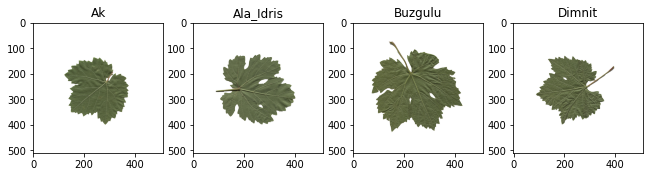

In [ ]:
plt.figure(figsize=(11,11))
l = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

for i in range(1, 5):

  plt.subplot(4,4,i)
  
  img=plt.imread(img_list[i-1])
  imshow(img)
  t = l[i-1]
  plt.title(t)
  

In [ ]:
path = pd.Series(path)
labels = pd.Series(label)
img_data = pd.DataFrame({'Path':path.values, 'Label':labels.values})

In [ ]:
print(img_data.head())
print(img_data.size)
print(img_data['Path'][0])

                                                Path Label
0  drive/MyDrive/datamining project/Grapevine_Lea...    Ak
1  drive/MyDrive/datamining project/Grapevine_Lea...    Ak
2  drive/MyDrive/datamining project/Grapevine_Lea...    Ak
3  drive/MyDrive/datamining project/Grapevine_Lea...    Ak
4  drive/MyDrive/datamining project/Grapevine_Lea...    Ak
1000
drive/MyDrive/datamining project/Grapevine_Leaves_Image_Dataset/Ak/Ak (15).png


### Pie chart
Drawing the chart of this dataset. The disturbution of different types of leaves apppear to be normal.

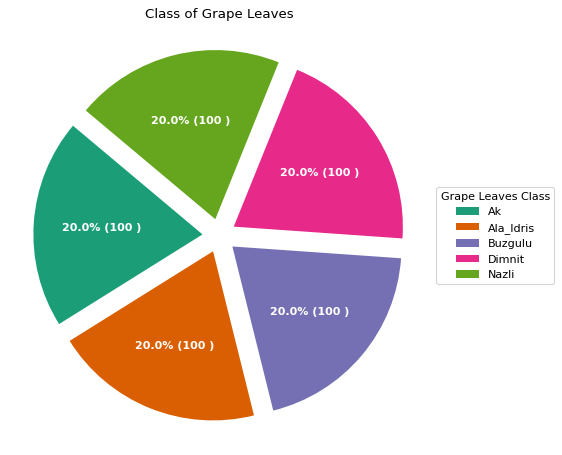

In [ ]:
df = img_data.groupby('Label').size().reset_index(name='counts')

# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df['counts']
categories = df['Label']
explode = [0.1,0.1,0.1,0.1,0.1]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="Grape Leaves Class", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Class of Grape Leaves")
plt.show()

### Test/Train splitting


In [ ]:
img_data = img_data.sample(frac=1, axis=0).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(img_data[['Path', 'Label']], img_data[['Label']], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val

,Path,Label
120,drive/MyDrive/datamining project/Grapevine_Lea...,Ak
128,drive/MyDrive/datamining project/Grapevine_Lea...,Ak
271,drive/MyDrive/datamining project/Grapevine_Lea...,Nazli
349,drive/MyDrive/datamining project/Grapevine_Lea...,Buzgulu
272,drive/MyDrive/datamining project/Grapevine_Lea...,Dimnit
...,...,...
498,drive/MyDrive/datamining project/Grapevine_Lea...,Nazli
242,drive/MyDrive/datamining project/Grapevine_Lea...,Ak
160,drive/MyDrive/datamining project/Grapevine_Lea...,Nazli
386,drive/MyDrive/datamining project/Grapevine_Lea...,Ala_Idris


### Generating data (augmentation of data)
Data Augmentation is a technique that can be used to artificially expand the size of a training set by creating modified data from the existing one. 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, rotation_range=20, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05, horizontal_flip=True, fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1 / 255.0)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
batch_size = 40

train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=batch_size, class_mode="categorical", subset='training', shuffle=True, seed=42)

validation_generator = val_datagen.flow_from_dataframe( dataframe=X_val, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)

test_generator = test_datagen.flow_from_dataframe( dataframe=X_test, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
cb = tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)
call_back = [cb]

### Confusion Matrix

In [ ]:
def report_results(model, y_true, y_predicted):

    y_predicted = np.argmax(y_predicted, axis=1)

    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    y_predicted = np.array([labels[k] for k in y_predicted])

    print("Accuracy score: ", accuracy_score(y_true, y_predicted))
    print(classification_report(y_true, y_predicted))

    mat = confusion_matrix(y_true, y_predicted)
    sns.heatmap(mat, annot=True, cmap="Blues")

### Pre- trained Models

#### VGG16

VGG16 is a convolution neural net (CNN ) architecture and the most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2.

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
vgg16 = VGG16(include_top = False, input_shape = (300,300,3), weights = 'imagenet')

# no need to train all the layers 
for layer in vgg16.layers:

    layer.trainable = False

x = GlobalAveragePooling2D()(vgg16.output)
# The softmax function, also known as softargmax or normalized exponential function, 
# converts a vector of K real numbers into a probability distribution of K possible outcomes. 
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg16.input, outputs = predictions)

model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])



history_vgg = model_vgg.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 10, epochs=25, callbacks = call_back)


Epoch 1/25
10/10 [==============================] - 14s 1s/step - loss: 1.7537 - accuracy: 0.1925 - val_loss: 1.6612 - val_accuracy: 0.2125
Epoch 2/25
10/10 [==============================] - 17s 2s/step - loss: 1.6361 - accuracy: 0.1200 - val_loss: 1.6216 - val_accuracy: 0.1250
Epoch 3/25
10/10 [==============================] - 13s 1s/step - loss: 1.6128 - accuracy: 0.2075 - val_loss: 1.6152 - val_accuracy: 0.2500
Epoch 4/25
10/10 [==============================] - 12s 1s/step - loss: 1.5952 - accuracy: 0.2400 - val_loss: 1.5949 - val_accuracy: 0.2625
Epoch 5/25
10/10 [==============================] - 12s 1s/step - loss: 1.5766 - accuracy: 0.3400 - val_loss: 1.5767 - val_accuracy: 0.3750
Epoch 6/25
10/10 [==============================] - 12s 1s/step - loss: 1.5609 - accuracy: 0.3875 - val_loss: 1.5631 - val_accuracy: 0.3750
Epoch 7/25
10/10 [==============================] - 12s 1s/step - loss: 1.5434 - accuracy: 0.4975 - val_loss: 1.5446 - val_accuracy: 0.4625
Epoch 8/25
10/10 [==

In [ ]:
print(model_vgg.evaluate(test_generator))

13/13 [==============================] - 1s 105ms/step - loss: 1.2593 - accuracy: 0.7000
[1.2592774629592896, 0.699999988079071]


In conclusion; a larger step per epoch and a larger epoch will give us better results.

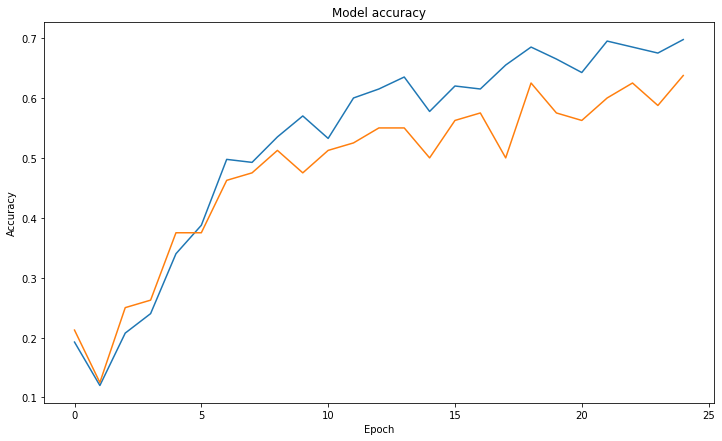

In [ ]:
# steps per epoch     epoch   accuracy (test)   accuracy(val)
#       8               10          0.46            0.43
#       8               25          0.67            0.61
#       10              25          0.70            0.63
#       10              50          0.70            0.63


plt.figure(figsize=(12,7))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Accuracy score:  0.7
              precision    recall  f1-score   support

          Ak       0.56      0.59      0.57        17
   Ala_Idris       0.54      0.74      0.62        19
     Buzgulu       0.79      0.83      0.81        23
      Dimnit       0.80      0.36      0.50        22
       Nazli       0.86      1.00      0.93        19

    accuracy                           0.70       100
   macro avg       0.71      0.70      0.69       100
weighted avg       0.72      0.70      0.69       100



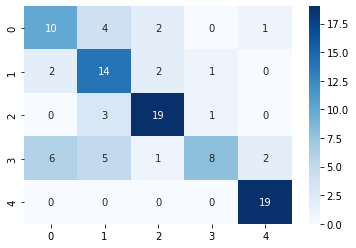

In [ ]:
y_predict = model_vgg.predict(test_generator)
report_results(model_vgg, np.array(X_test['Label']), y_predict)

#### VGG19

VGG19 architecture is a variant of the VGG model, consist of 16 convolutional neural networks, 3 FC layers, 5 MaxPool layers and 1 SoftMax layer. The fixed-size input images a 224 by 224 pixel with three channels (R, G, and B) which means that the matrix is of shape (224,224,3).

In [ ]:


vgg19 = VGG19(include_top = False, input_shape = (300,300,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])



history_vgg = model_vgg.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch = 10, 
      epochs=25,
      callbacks = call_back)



Epoch 1/25
10/10 [==============================] - 13s 1s/step - loss: 1.7764 - accuracy: 0.2050 - val_loss: 1.6381 - val_accuracy: 0.1125
Epoch 2/25
10/10 [==============================] - 12s 1s/step - loss: 1.6339 - accuracy: 0.1700 - val_loss: 1.6294 - val_accuracy: 0.2000
Epoch 3/25
10/10 [==============================] - 12s 1s/step - loss: 1.6199 - accuracy: 0.1875 - val_loss: 1.6040 - val_accuracy: 0.2125
Epoch 4/25
10/10 [==============================] - 12s 1s/step - loss: 1.5977 - accuracy: 0.2575 - val_loss: 1.5939 - val_accuracy: 0.3125
Epoch 5/25
10/10 [==============================] - 12s 1s/step - loss: 1.5914 - accuracy: 0.2875 - val_loss: 1.5859 - val_accuracy: 0.3250
Epoch 6/25
10/10 [==============================] - 13s 1s/step - loss: 1.5633 - accuracy: 0.3450 - val_loss: 1.5671 - val_accuracy: 0.3625
Epoch 7/25
10/10 [==============================] - 12s 1s/step - loss: 1.5564 - accuracy: 0.4125 - val_loss: 1.5570 - val_accuracy: 0.3750
Epoch 8/25
10/10 [==

In [ ]:
print(model_vgg.evaluate(test_generator))

13/13 [==============================] - 2s 129ms/step - loss: 1.2864 - accuracy: 0.6700
[1.2864181995391846, 0.6700000166893005]


A larger step per epoch and a larger epoch will give us better results.

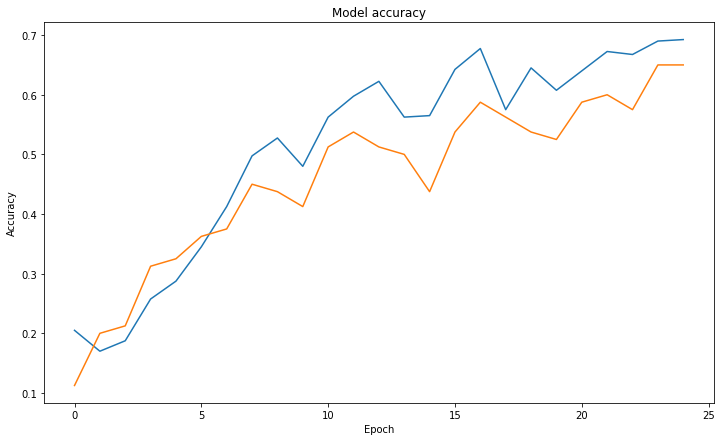

In [ ]:
# steps per epoch     epoch   accuracy (test)   accuracy(val)
#       8               10          0.63            0.51
#       8               25          0.67            0.60        model accuracy started to fall after epoch 20/25
#       10              25          0.67            0.65


plt.figure(figsize=(12,7))
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Accuracy score:  0.67
              precision    recall  f1-score   support

          Ak       0.56      0.59      0.57        17
   Ala_Idris       0.52      0.79      0.62        19
     Buzgulu       0.92      0.48      0.63        23
      Dimnit       0.80      0.55      0.65        22
       Nazli       0.73      1.00      0.84        19

    accuracy                           0.67       100
   macro avg       0.70      0.68      0.66       100
weighted avg       0.72      0.67      0.66       100



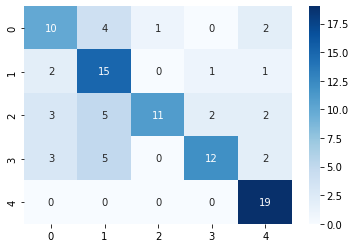

In [ ]:
y_predict = model_vgg.predict(test_generator)
report_results(model_vgg, np.array(X_test['Label']), y_predict)

#### Resnet101

ResNet-101 is a convolutional neural network that is 101 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 

In [ ]:
resnet101 = ResNet101(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet101.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet101.output)
predictions = Dense(5, activation='softmax')(x)

model_resnet101 = Model(inputs = resnet101.input, outputs = predictions)

171458560/171446536 [==============================] - 5s 0us/step


In [ ]:
model_resnet101.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_resnet101 = model_resnet101.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch = 10, 
      epochs=25,
      callbacks = call_back)


Epoch 1/25
10/10 [==============================] - 14s 1s/step - loss: 1.4959 - accuracy: 0.3325 - val_loss: 1.4870 - val_accuracy: 0.3250
Epoch 2/25
10/10 [==============================] - 12s 1s/step - loss: 1.5058 - accuracy: 0.3700 - val_loss: 1.4804 - val_accuracy: 0.3750
Epoch 3/25
10/10 [==============================] - 12s 1s/step - loss: 1.4918 - accuracy: 0.3525 - val_loss: 1.5407 - val_accuracy: 0.2500
Epoch 4/25
10/10 [==============================] - 12s 1s/step - loss: 1.4939 - accuracy: 0.3475 - val_loss: 1.5011 - val_accuracy: 0.3375
Epoch 5/25
10/10 [==============================] - 12s 1s/step - loss: 1.5344 - accuracy: 0.3000 - val_loss: 1.4912 - val_accuracy: 0.3250
Epoch 6/25
10/10 [==============================] - 12s 1s/step - loss: 1.4974 - accuracy: 0.3625 - val_loss: 1.4770 - val_accuracy: 0.3750
Epoch 7/25
10/10 [==============================] - 12s 1s/step - loss: 1.4817 - accuracy: 0.3250 - val_loss: 1.4895 - val_accuracy: 0.3875
Epoch 8/25
10/10 [==

In [ ]:
print(model_resnet101.evaluate(test_generator))

13/13 [==============================] - 1s 102ms/step - loss: 1.3272 - accuracy: 0.4500
[1.327176570892334, 0.44999998807907104]


A larger step per epoch and a larger epoch will give us similar results. It is noteworthy that accuracy falls after epoch 20/25.

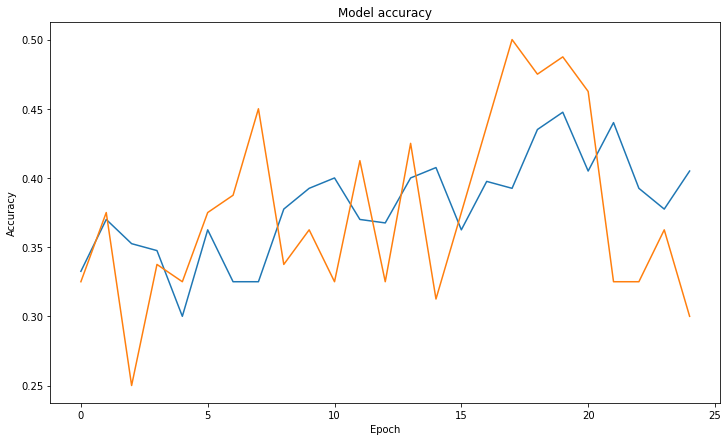

In [ ]:
# steps per epoch     epoch   accuracy (test)   accuracy(val)
#       8               10          0.38            0.31
#       8               25          0.46            0.40
#       10              25          0.45            0.48


plt.figure(figsize=(12,7))
plt.plot(history_resnet101.history['accuracy'])
plt.plot(history_resnet101.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Inception

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in inception.layers[:-15]:
    layer.trainable = False

inception_model = Sequential([
        inception,
        GlobalAveragePooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

inception_model.compile(
        optimizer= 'adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"])

inception_history = inception_model.fit(train_generator, 
                    steps_per_epoch = 5, 
                    validation_data = validation_generator,
                    validation_steps = 2,
                    epochs = 15,
                    callbacks = call_back)

Epoch 1/15
5/5 [==============================] - 16s 2s/step - loss: 1.8318 - accuracy: 0.2200 - val_loss: 1.6732 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 5s 1s/step - loss: 1.4424 - accuracy: 0.3700 - val_loss: 1.2835 - val_accuracy: 0.3750
Epoch 3/15
5/5 [==============================] - 5s 1s/step - loss: 1.2683 - accuracy: 0.4600 - val_loss: 1.1083 - val_accuracy: 0.5625
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 1.1411 - accuracy: 0.5450 - val_loss: 0.7934 - val_accuracy: 0.7500
Epoch 5/15
5/5 [==============================] - 5s 1s/step - loss: 0.9788 - accuracy: 0.5900 - val_loss: 0.9080 - val_accuracy: 0.6875
Epoch 6/15
5/5 [==============================] - 5s 1s/step - loss: 0.9495 - accuracy: 0.6600 - val_loss: 0.7579 - val_accuracy: 0.7500
Epoch 7/15
5/5 [==============================] - 5s 1s/step - loss: 0.8585 - accuracy: 0.6700 - val_loss: 0.5444 - val_accuracy: 0.8750
Epoch 8/15
5/5 [========================

In [ ]:
print(inception_model.evaluate(test_generator))

13/13 [==============================] - 1s 76ms/step - loss: 0.5062 - accuracy: 0.7900
[0.5061849355697632, 0.7900000214576721]


Our model overfits if the number of epoch and step per epoch goes up!

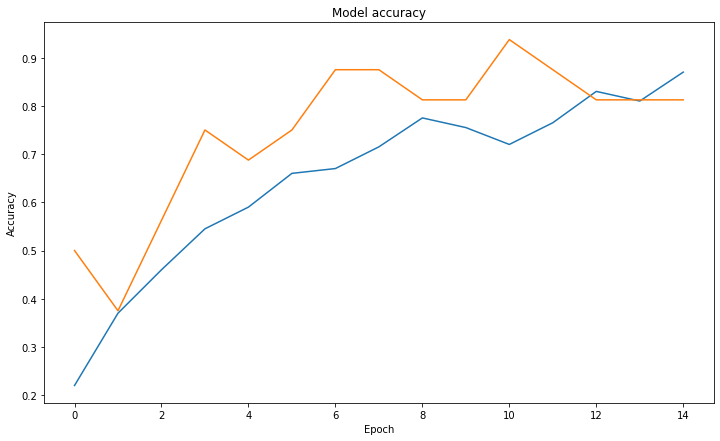

In [ ]:
# steps per epoch     epoch   accuracy (test)   accuracy(val)
#       8               10          0.63            0.87
#       8               25          0.93            1.00      the model is overfitting
#       5               15          0.80            0.93

plt.figure(figsize=(12,7))
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Accuracy score:  0.79
              precision    recall  f1-score   support

          Ak       0.74      0.82      0.78        17
   Ala_Idris       0.78      0.95      0.86        19
     Buzgulu       1.00      0.65      0.79        23
      Dimnit       0.87      0.59      0.70        22
       Nazli       0.68      1.00      0.81        19

    accuracy                           0.79       100
   macro avg       0.81      0.80      0.79       100
weighted avg       0.82      0.79      0.78       100



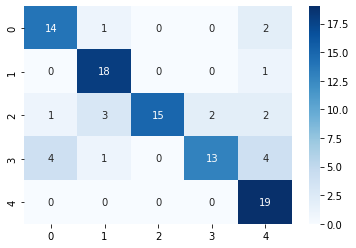

In [ ]:
y_predict = inception_model.predict(test_generator)
report_results(inception_model, np.array(X_test['Label']), y_predict)

### K-folds cross validation

#### VGG19
Better results with K-folds
we have val accuracy of 76 and test accuracy of 79 for epoch 10 and 8 steps.

Found 100 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 1.2473 - accuracy: 0.7063 - val_loss: 1.2935 - val_accuracy: 0.6750
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.2319 - accuracy: 0.7063 - val_loss: 1.2910 - val_accuracy: 0.6500
Epoch 3/10
8/8 [==============================] - 12s 1s/step - loss: 1.2387 - accuracy: 0.7063 - val_loss: 1.2878 - val_accuracy: 0.6875
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.2323 - accuracy: 0.7094 - val_loss: 1.2827 - val_accuracy: 0.6750
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.2120 - accuracy: 0.7437 - val_loss: 1.2670 - val_accuracy: 0.6625
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.2086 - accuracy: 0.7437 - val_loss: 1.2666 - val_accuracy: 

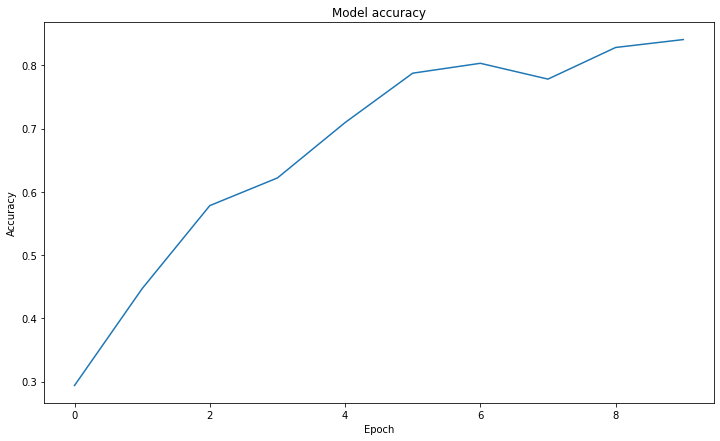

10/10 [==============================] - 1s 129ms/step - loss: 1.2439 - accuracy: 0.7000
val:  [1.2438863515853882, 0.699999988079071]


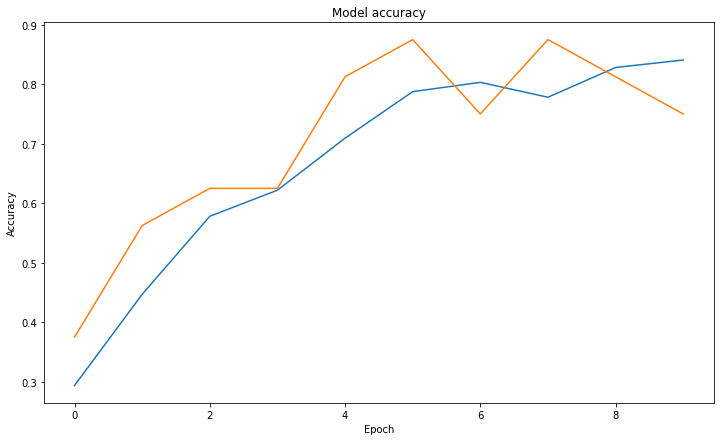

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.1737 - accuracy: 0.7031 - val_loss: 1.2428 - val_accuracy: 0.6750
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.1712 - accuracy: 0.7469 - val_loss: 1.2259 - val_accuracy: 0.6875
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.1603 - accuracy: 0.7375 - val_loss: 1.2285 - val_accuracy: 0.6750
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.1557 - accuracy: 0.7375 - val_loss: 1.2318 - val_accuracy: 0.6500
Epoch 5/10
8/8 [==============================] - 13s 2s/step - loss: 1.1581 - accuracy: 0.7063 - val_loss: 1.2137 - val_accuracy: 0.6625
Epoch 6/10
8/8 [==============================] - 13s 2s/step - loss: 1.1544 - accuracy: 0.7188 - val_loss: 1.2072 - val_accuracy: 0.6875
Epoch 7/10
8/8 [==============================] - 10s

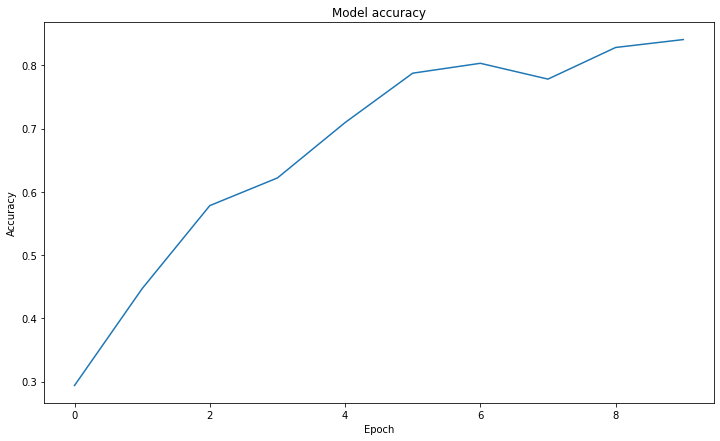

10/10 [==============================] - 1s 129ms/step - loss: 1.1907 - accuracy: 0.7000
val:  [1.1906898021697998, 0.699999988079071]


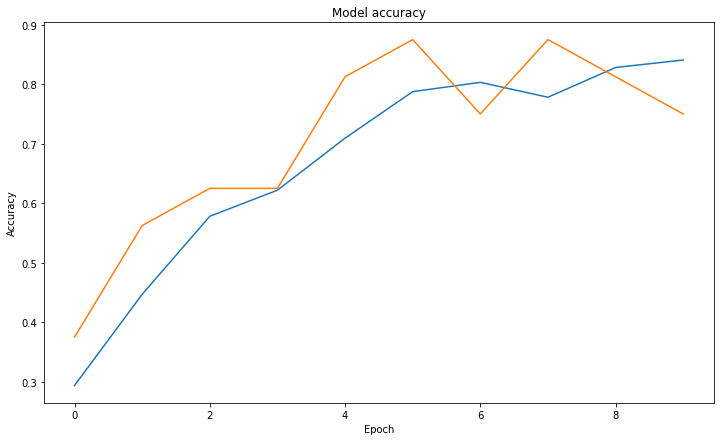

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.1156 - accuracy: 0.7250 - val_loss: 1.1800 - val_accuracy: 0.7125
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.1233 - accuracy: 0.7437 - val_loss: 1.1791 - val_accuracy: 0.6625
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 1.1121 - accuracy: 0.7469 - val_loss: 1.1749 - val_accuracy: 0.7125
Epoch 4/10
8/8 [==============================] - 14s 2s/step - loss: 1.1021 - accuracy: 0.7625 - val_loss: 1.1777 - val_accuracy: 0.6750
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 1.0949 - accuracy: 0.7125 - val_loss: 1.1658 - val_accuracy: 0.7125
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.0776 - accuracy: 0.7531 - val_loss: 1.1715 - val_accuracy: 0.6750
Epoch 7/10
8/8 [==============================] - 10s

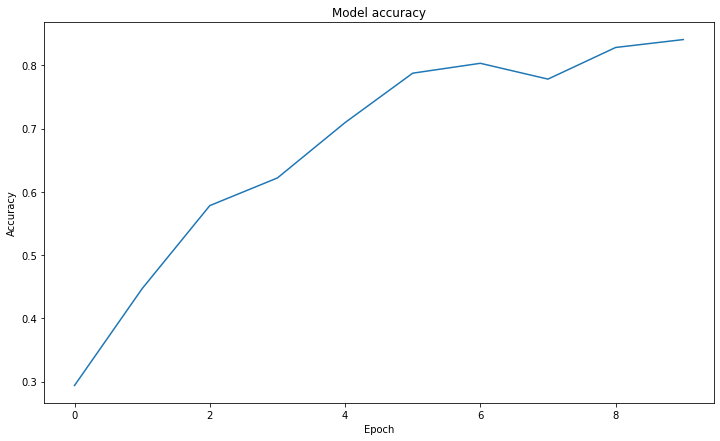

10/10 [==============================] - 1s 133ms/step - loss: 1.1435 - accuracy: 0.7125
val:  [1.1435301303863525, 0.7124999761581421]


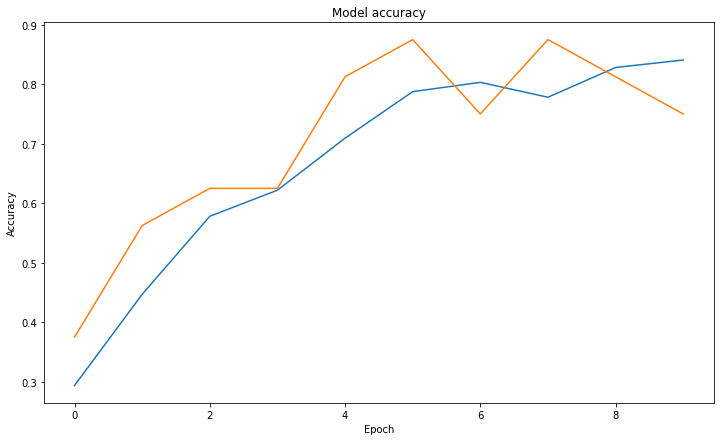

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 1.0521 - accuracy: 0.7594 - val_loss: 1.1454 - val_accuracy: 0.6875
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.0367 - accuracy: 0.7750 - val_loss: 1.1375 - val_accuracy: 0.7000
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.0369 - accuracy: 0.7344 - val_loss: 1.1295 - val_accuracy: 0.7125
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.0422 - accuracy: 0.7406 - val_loss: 1.1245 - val_accuracy: 0.7125
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.0331 - accuracy: 0.7625 - val_loss: 1.1205 - val_accuracy: 0.7125
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.0333 - accuracy: 0.7688 - val_loss: 1.1119 - val_accuracy: 0.7000
Epoch 7/10
8/8 [==============================] - 10s

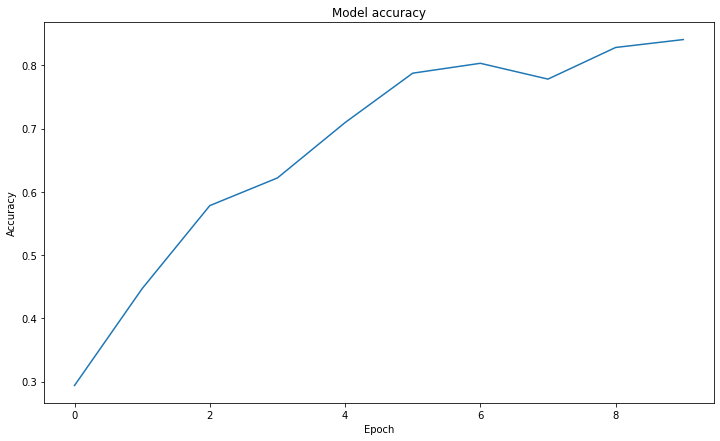

10/10 [==============================] - 1s 130ms/step - loss: 1.1052 - accuracy: 0.7125
val:  [1.105241060256958, 0.7124999761581421]


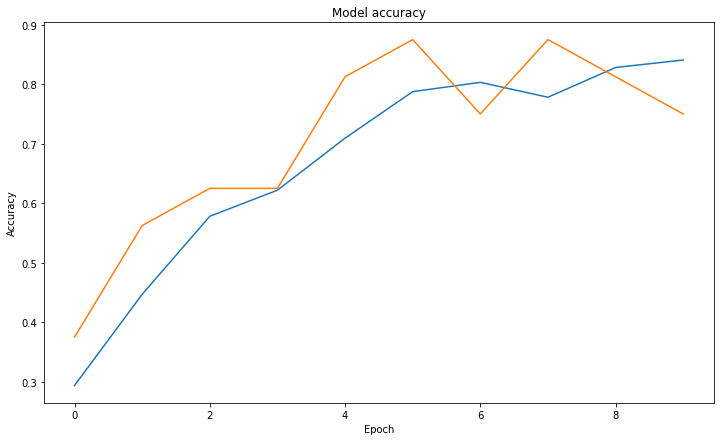

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.0219 - accuracy: 0.7406 - val_loss: 1.0969 - val_accuracy: 0.7125
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.0177 - accuracy: 0.7719 - val_loss: 1.0870 - val_accuracy: 0.7250
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.0190 - accuracy: 0.7250 - val_loss: 1.0861 - val_accuracy: 0.7125
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.0083 - accuracy: 0.7625 - val_loss: 1.0854 - val_accuracy: 0.7125
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.9923 - accuracy: 0.7688 - val_loss: 1.0804 - val_accuracy: 0.7250
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.9858 - accuracy: 0.7781 - val_loss: 1.0764 - val_accuracy: 0.7000
Epoch 7/10
8/8 [==============================] - 10s

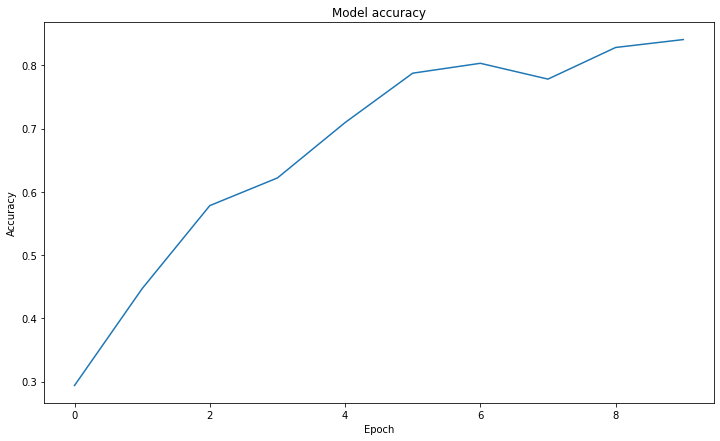

10/10 [==============================] - 1s 130ms/step - loss: 1.0649 - accuracy: 0.7125
val:  [1.0648746490478516, 0.7124999761581421]


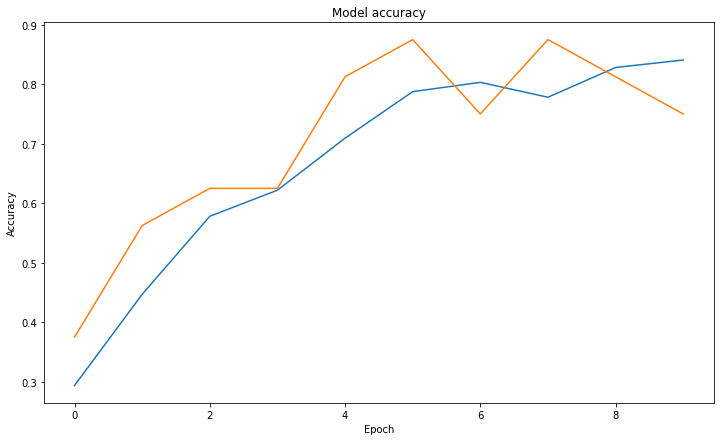

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 0.9886 - accuracy: 0.7250 - val_loss: 1.0591 - val_accuracy: 0.7375
Epoch 2/10
8/8 [==============================] - 13s 2s/step - loss: 0.9746 - accuracy: 0.7594 - val_loss: 1.0634 - val_accuracy: 0.7000
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.9850 - accuracy: 0.7625 - val_loss: 1.0578 - val_accuracy: 0.7000
Epoch 4/10
8/8 [==============================] - 12s 1s/step - loss: 0.9666 - accuracy: 0.7625 - val_loss: 1.0449 - val_accuracy: 0.7250
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.9677 - accuracy: 0.7500 - val_loss: 1.0445 - val_accuracy: 0.7500
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.9948 - accuracy: 0.7469 - val_loss: 1.0470 - val_accuracy: 0.7375
Epoch 7/10
8/8 [==============================] - 10s

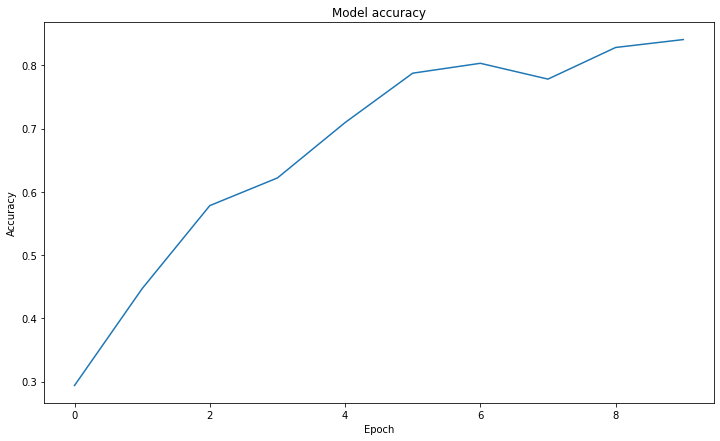

10/10 [==============================] - 1s 131ms/step - loss: 1.0289 - accuracy: 0.7375
val:  [1.0288500785827637, 0.737500011920929]


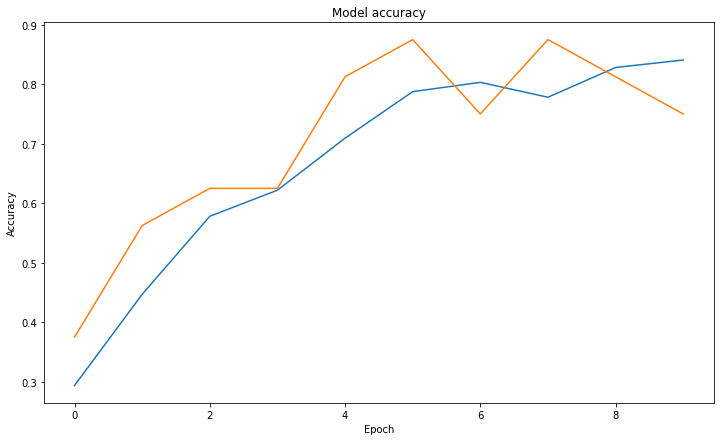

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 0.9334 - accuracy: 0.7563 - val_loss: 1.0262 - val_accuracy: 0.7375
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.9203 - accuracy: 0.7875 - val_loss: 1.0370 - val_accuracy: 0.7125
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.9389 - accuracy: 0.7750 - val_loss: 1.0207 - val_accuracy: 0.7125
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.9054 - accuracy: 0.7875 - val_loss: 1.0092 - val_accuracy: 0.7375
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.9081 - accuracy: 0.8062 - val_loss: 1.0134 - val_accuracy: 0.7375
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.9117 - accuracy: 0.7656 - val_loss: 1.0078 - val_accuracy: 0.7375
Epoch 7/10
8/8 [==============================] - 12s

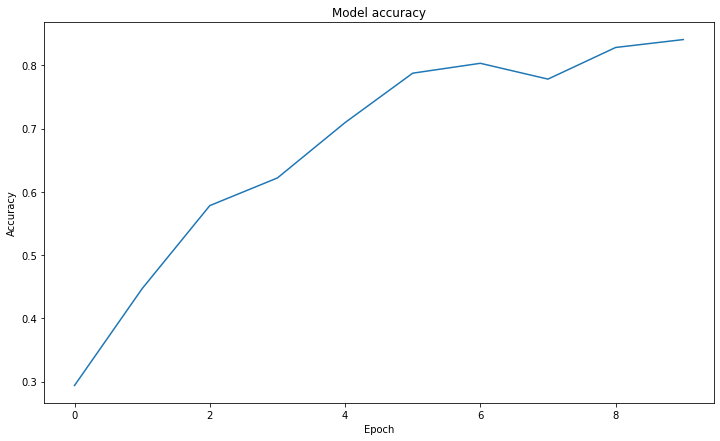

10/10 [==============================] - 1s 132ms/step - loss: 0.9990 - accuracy: 0.7375
val:  [0.9989591836929321, 0.737500011920929]


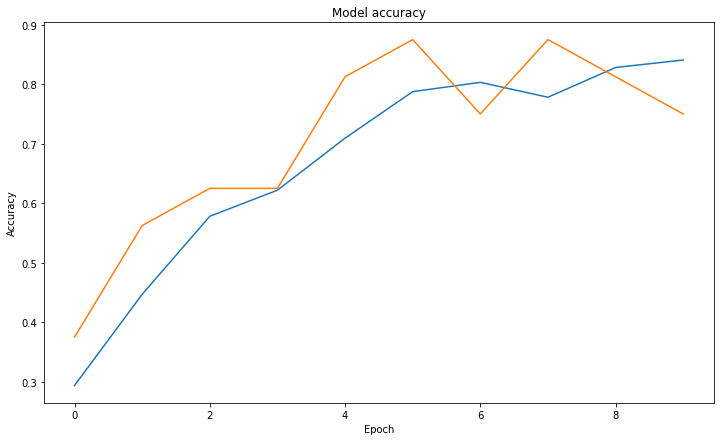

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 0.9026 - accuracy: 0.7969 - val_loss: 0.9900 - val_accuracy: 0.7500
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.9066 - accuracy: 0.7875 - val_loss: 0.9852 - val_accuracy: 0.7375
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.8995 - accuracy: 0.7875 - val_loss: 0.9893 - val_accuracy: 0.7375
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.9116 - accuracy: 0.7875 - val_loss: 0.9887 - val_accuracy: 0.7250
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.8690 - accuracy: 0.8281 - val_loss: 0.9829 - val_accuracy: 0.7375
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.9223 - accuracy: 0.7688 - val_loss: 0.9851 - val_accuracy: 0.7500
Epoch 7/10
8/8 [==============================] - 10s

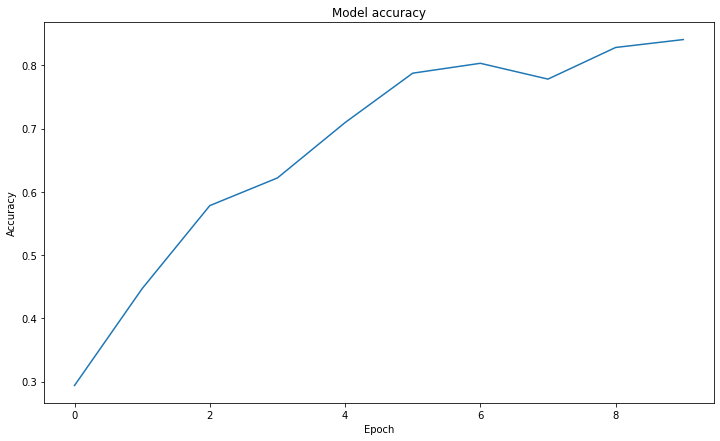

10/10 [==============================] - 1s 129ms/step - loss: 0.9718 - accuracy: 0.7375
val:  [0.9717909097671509, 0.737500011920929]


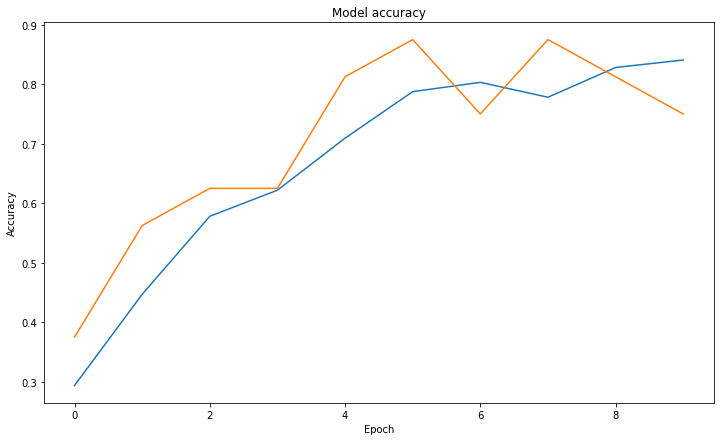

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 0.8798 - accuracy: 0.7781 - val_loss: 0.9738 - val_accuracy: 0.7250
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 0.8632 - accuracy: 0.7688 - val_loss: 0.9793 - val_accuracy: 0.7375
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.8931 - accuracy: 0.7719 - val_loss: 0.9639 - val_accuracy: 0.7500
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.8619 - accuracy: 0.7906 - val_loss: 0.9658 - val_accuracy: 0.7375
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.8388 - accuracy: 0.8156 - val_loss: 0.9573 - val_accuracy: 0.7625
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.8614 - accuracy: 0.7875 - val_loss: 0.9456 - val_accuracy: 0.7500
Epoch 7/10
8/8 [==============================] - 12s

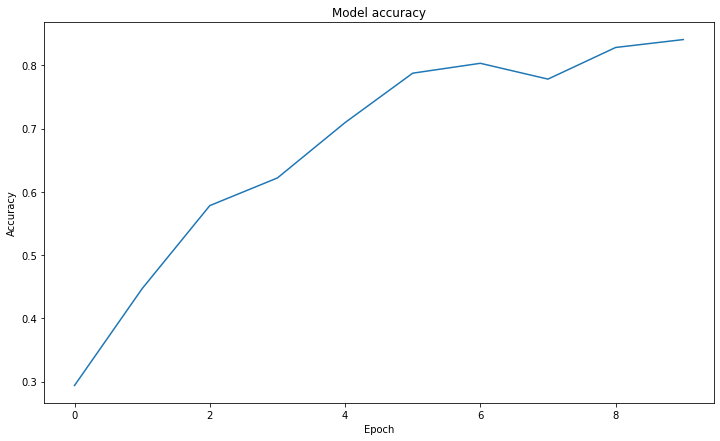

10/10 [==============================] - 1s 131ms/step - loss: 0.9342 - accuracy: 0.7500
val:  [0.9342223405838013, 0.75]


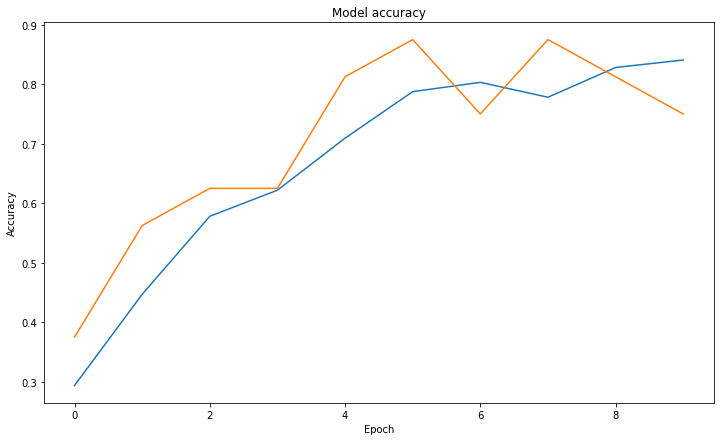

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 0.8472 - accuracy: 0.8250 - val_loss: 0.9332 - val_accuracy: 0.7500
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.8406 - accuracy: 0.8156 - val_loss: 0.9318 - val_accuracy: 0.7625
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 0.8382 - accuracy: 0.8062 - val_loss: 0.9398 - val_accuracy: 0.7625
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.8712 - accuracy: 0.7812 - val_loss: 0.9476 - val_accuracy: 0.7375
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.8462 - accuracy: 0.7875 - val_loss: 0.9292 - val_accuracy: 0.7625
Epoch 6/10
8/8 [==============================] - 12s 1s/step - loss: 0.8652 - accuracy: 0.7906 - val_loss: 0.9272 - val_accuracy: 0.7375
Epoch 7/10
8/8 [==============================] - 10s

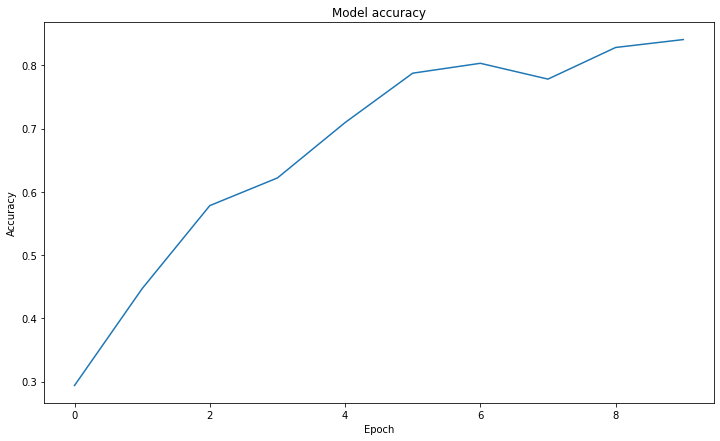

10/10 [==============================] - 1s 131ms/step - loss: 0.9226 - accuracy: 0.7375
val:  [0.9225624203681946, 0.737500011920929]


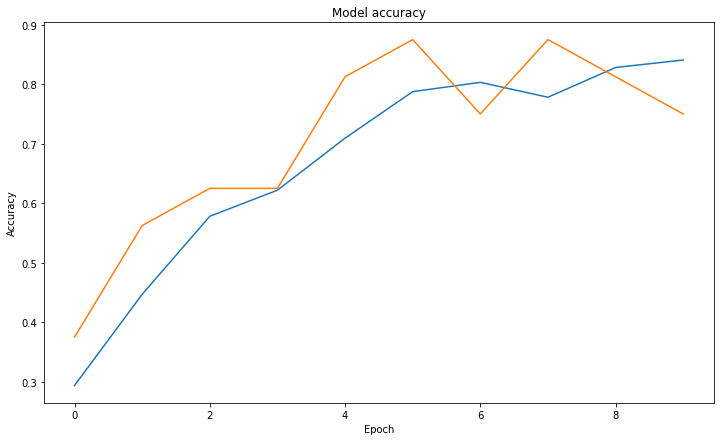

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(img_data[['Path', 'Label']], img_data[['Label']], test_size=0.2, random_state=42)
Y = y_train

test_generator = test_datagen.flow_from_dataframe( dataframe=X_test, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)


for train_index, val_index in kf.split(np.zeros(400),Y):



  training_data = X_train.iloc[train_index]
  validation_data = X_train.iloc[val_index]

 
  batch_size = 40
  train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=batch_size, class_mode="categorical", subset='training', shuffle=True, seed=42)
  validation_generator = val_datagen.flow_from_dataframe( dataframe=X_val, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)

  
  history_vgg = model_vgg.fit(
        train_generator,
        validation_data=validation_generator,
        steps_per_epoch = 8, 
        epochs=10,
        callbacks = call_back)
  
  print('test: ', model_vgg.evaluate(test_generator))
  plt.figure(figsize=(12,7))
  plt.plot(inception_history.history['accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

  print('val: ',model_vgg.evaluate(validation_generator))
  plt.figure(figsize=(12,7))
  plt.plot(inception_history.history['accuracy'])
  plt.plot(inception_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()



#### Resnet101

Worse results with K-folds
we have val accuracy of 56 and test accuracy of 62 for epoch 10 and 8 steps.

Found 100 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.5615 - accuracy: 0.3281 - val_loss: 1.5905 - val_accuracy: 0.3125
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 1.5513 - accuracy: 0.3750 - val_loss: 1.5730 - val_accuracy: 0.3000
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 1.5752 - accuracy: 0.2500 - val_loss: 1.5710 - val_accuracy: 0.2375
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.5507 - accuracy: 0.3562 - val_loss: 1.5526 - val_accuracy: 0.3250
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.5352 - accuracy: 0.3812 - val_loss: 1.5442 - val_accuracy: 0.3500
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.5448 - accuracy: 0.3344 - val_loss: 1.5316 - val_accuracy: 

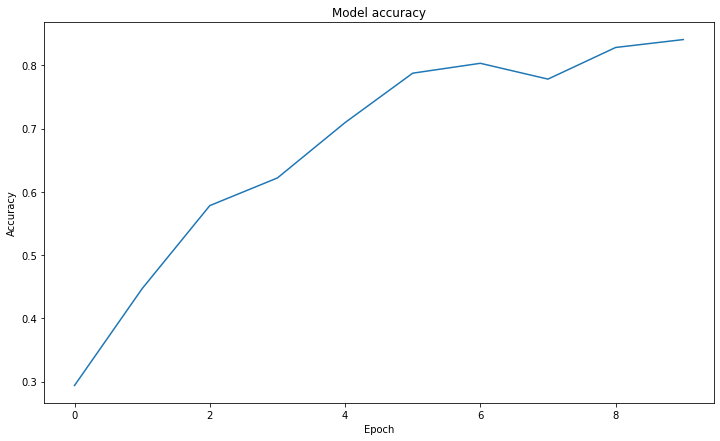

10/10 [==============================] - 1s 99ms/step - loss: 1.5356 - accuracy: 0.3000
val:  [1.5356088876724243, 0.30000001192092896]


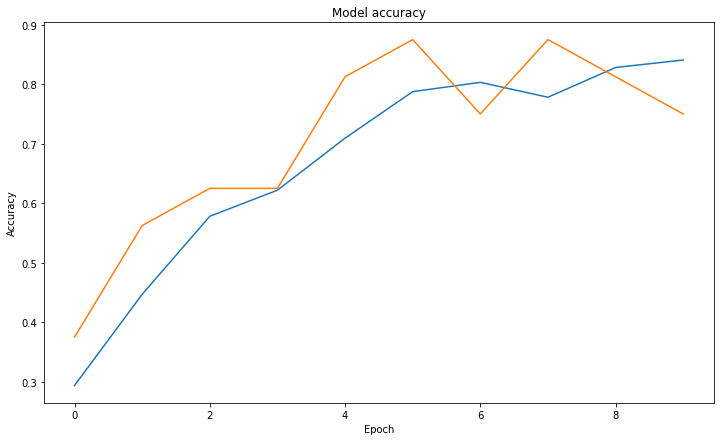

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 1.5062 - accuracy: 0.3625 - val_loss: 1.5251 - val_accuracy: 0.3750
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 1.5100 - accuracy: 0.3781 - val_loss: 1.5228 - val_accuracy: 0.3500
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 1.4989 - accuracy: 0.3438 - val_loss: 1.5118 - val_accuracy: 0.3625
Epoch 4/10
8/8 [==============================] - 12s 2s/step - loss: 1.5052 - accuracy: 0.3625 - val_loss: 1.5089 - val_accuracy: 0.3375
Epoch 5/10
8/8 [==============================] - 12s 2s/step - loss: 1.4981 - accuracy: 0.3969 - val_loss: 1.5008 - val_accuracy: 0.3625
Epoch 6/10
8/8 [==============================] - 16s 2s/step - loss: 1.5134 - accuracy: 0.3219 - val_loss: 1.5200 - val_accuracy: 0.3750
Epoch 7/10
8/8 [==============================] - 13s

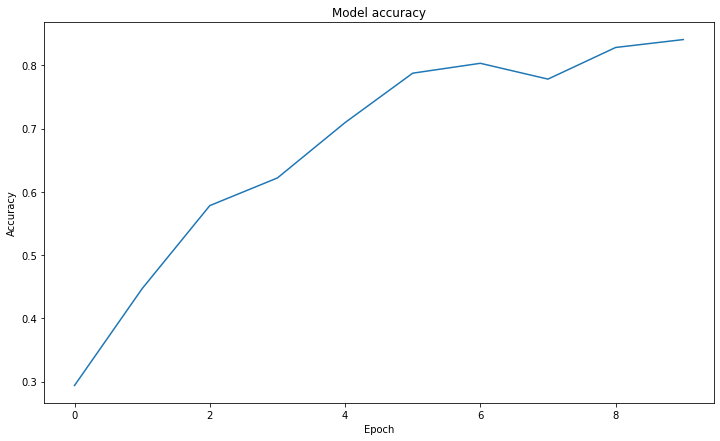

10/10 [==============================] - 1s 125ms/step - loss: 1.4897 - accuracy: 0.4250
val:  [1.489682912826538, 0.42500001192092896]


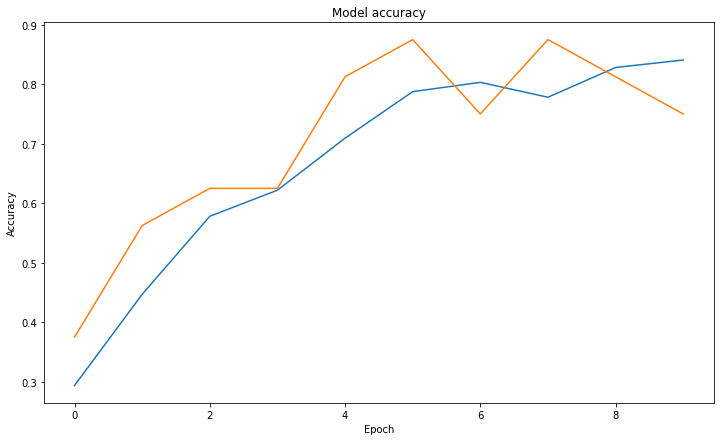

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 15s 2s/step - loss: 1.4618 - accuracy: 0.4406 - val_loss: 1.4673 - val_accuracy: 0.4125
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 1.4717 - accuracy: 0.3750 - val_loss: 1.4795 - val_accuracy: 0.4000
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 1.4748 - accuracy: 0.3844 - val_loss: 1.4642 - val_accuracy: 0.3375
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.4755 - accuracy: 0.3844 - val_loss: 1.4877 - val_accuracy: 0.3750
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.4738 - accuracy: 0.3656 - val_loss: 1.4574 - val_accuracy: 0.3875
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 1.4865 - accuracy: 0.3500 - val_loss: 1.4564 - val_accuracy: 0.4750
Epoch 7/10
8/8 [==============================] - 12s

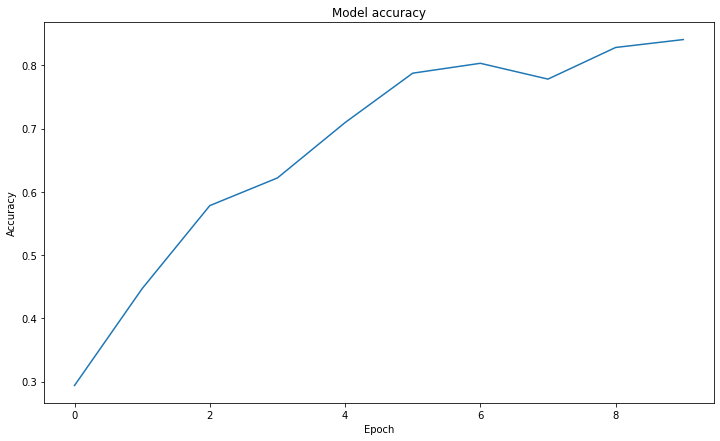

10/10 [==============================] - 1s 133ms/step - loss: 1.4571 - accuracy: 0.4500
val:  [1.4570822715759277, 0.44999998807907104]


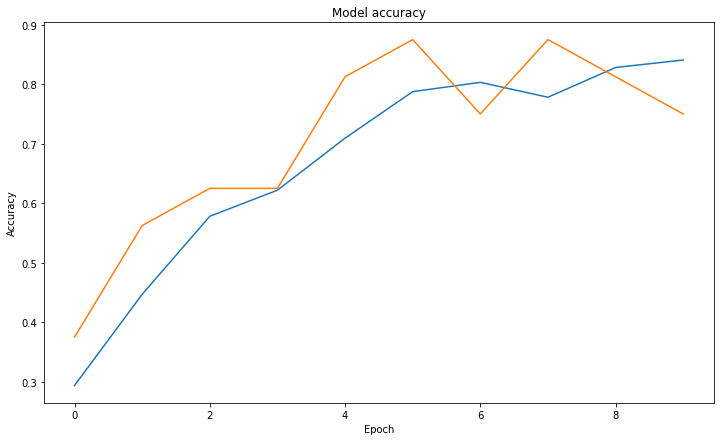

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 1.4394 - accuracy: 0.4187 - val_loss: 1.4674 - val_accuracy: 0.3250
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 1.4550 - accuracy: 0.3594 - val_loss: 1.4430 - val_accuracy: 0.4500
Epoch 3/10
8/8 [==============================] - 14s 2s/step - loss: 1.4640 - accuracy: 0.4000 - val_loss: 1.4564 - val_accuracy: 0.4500
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 1.4654 - accuracy: 0.3719 - val_loss: 1.4447 - val_accuracy: 0.3500
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 1.4226 - accuracy: 0.4688 - val_loss: 1.4850 - val_accuracy: 0.4500
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.4296 - accuracy: 0.3906 - val_loss: 1.4236 - val_accuracy: 0.3875
Epoch 7/10
8/8 [==============================] - 10s

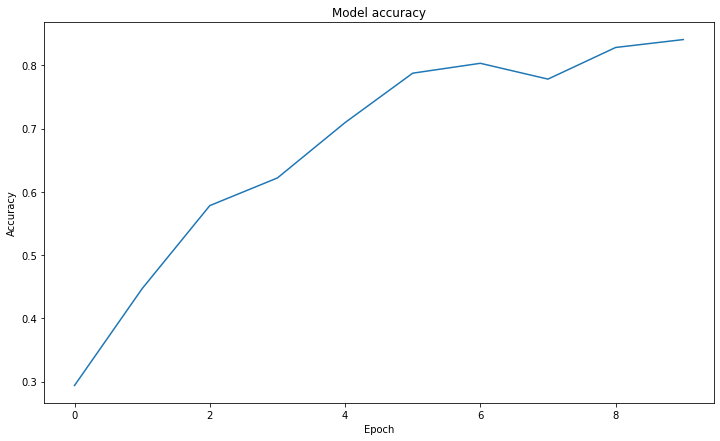

10/10 [==============================] - 1s 105ms/step - loss: 1.4223 - accuracy: 0.4125
val:  [1.4222698211669922, 0.4124999940395355]


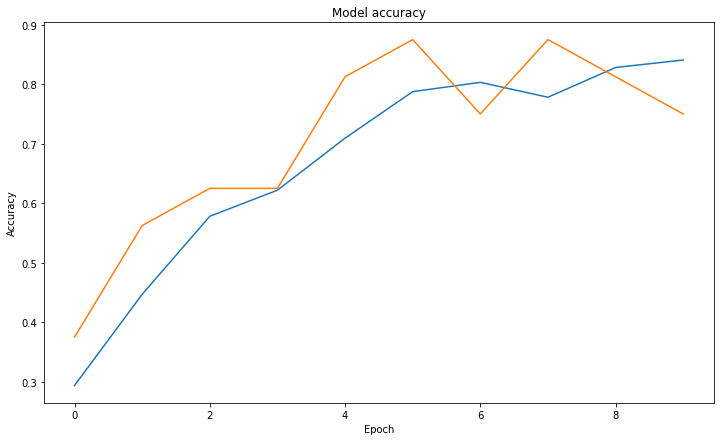

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.4167 - accuracy: 0.4375 - val_loss: 1.4129 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3895 - accuracy: 0.4219 - val_loss: 1.4144 - val_accuracy: 0.4625
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.4140 - accuracy: 0.3938 - val_loss: 1.4031 - val_accuracy: 0.4625
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.4017 - accuracy: 0.4531 - val_loss: 1.4304 - val_accuracy: 0.4125
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.4227 - accuracy: 0.3875 - val_loss: 1.4090 - val_accuracy: 0.4125
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.4163 - accuracy: 0.4469 - val_loss: 1.4018 - val_accuracy: 0.4750
Epoch 7/10
8/8 [==============================] - 10s

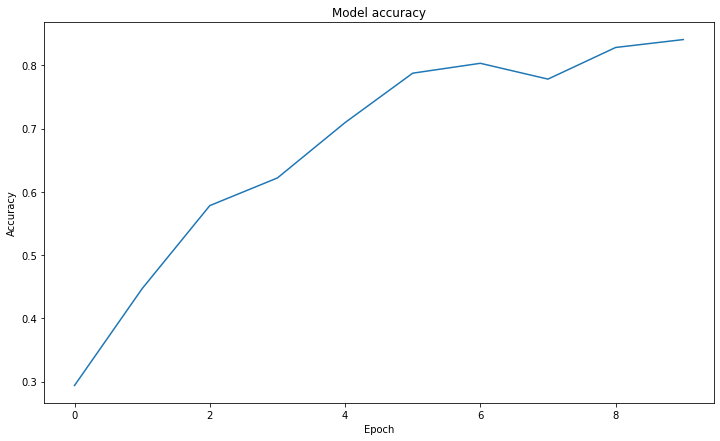

10/10 [==============================] - 1s 107ms/step - loss: 1.4035 - accuracy: 0.3500
val:  [1.403451919555664, 0.3499999940395355]


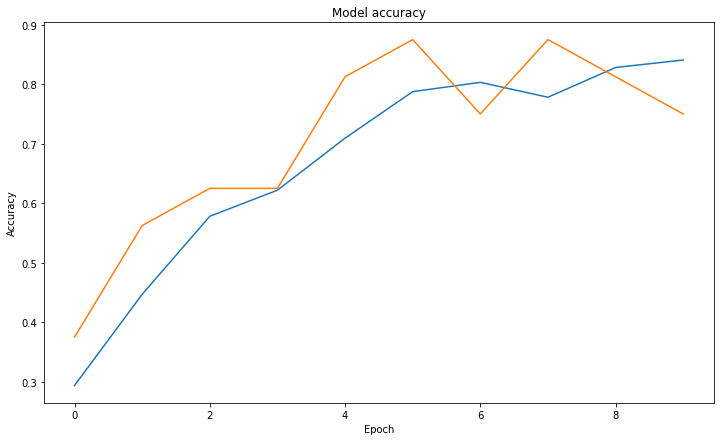

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.3909 - accuracy: 0.4094 - val_loss: 1.4180 - val_accuracy: 0.3375
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3674 - accuracy: 0.4594 - val_loss: 1.3855 - val_accuracy: 0.4500
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.4119 - accuracy: 0.4094 - val_loss: 1.3976 - val_accuracy: 0.4000
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.4207 - accuracy: 0.4062 - val_loss: 1.4053 - val_accuracy: 0.4000
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.4061 - accuracy: 0.3969 - val_loss: 1.3953 - val_accuracy: 0.4375
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 1.4108 - accuracy: 0.3750 - val_loss: 1.4009 - val_accuracy: 0.4000
Epoch 7/10
8/8 [==============================] - 10s

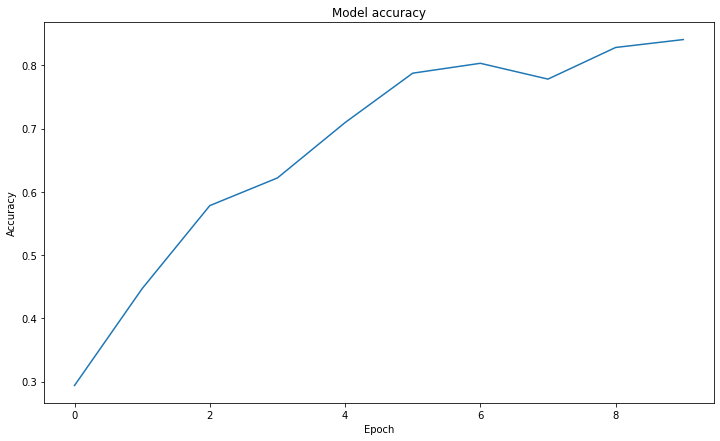

10/10 [==============================] - 1s 106ms/step - loss: 1.3768 - accuracy: 0.5500
val:  [1.3767908811569214, 0.550000011920929]


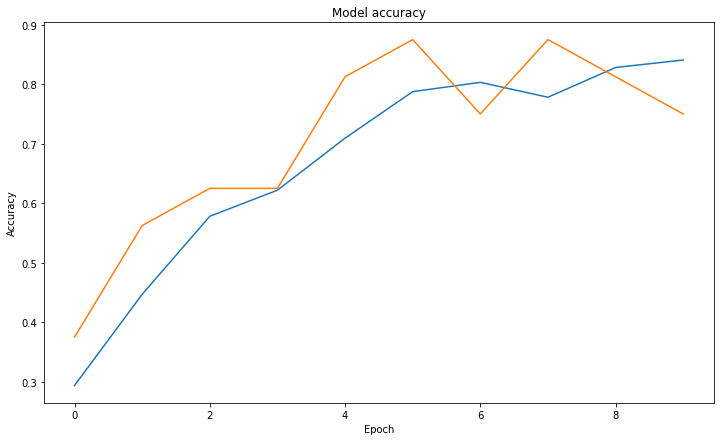

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.3663 - accuracy: 0.4469 - val_loss: 1.4248 - val_accuracy: 0.3875
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3782 - accuracy: 0.4656 - val_loss: 1.3762 - val_accuracy: 0.4125
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.3527 - accuracy: 0.4812 - val_loss: 1.4046 - val_accuracy: 0.3625
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.3607 - accuracy: 0.4313 - val_loss: 1.3831 - val_accuracy: 0.4375
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 1.3510 - accuracy: 0.5000 - val_loss: 1.3645 - val_accuracy: 0.4500
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.3636 - accuracy: 0.4531 - val_loss: 1.3732 - val_accuracy: 0.4375
Epoch 7/10
8/8 [==============================] - 10s

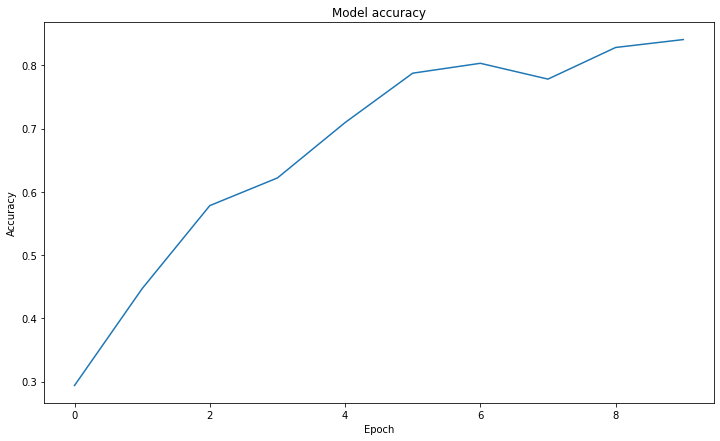

10/10 [==============================] - 1s 110ms/step - loss: 1.3439 - accuracy: 0.4750
val:  [1.3438633680343628, 0.4749999940395355]


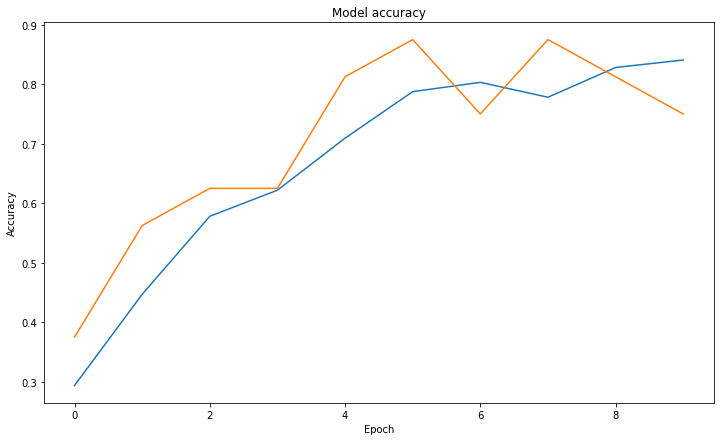

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.3487 - accuracy: 0.4938 - val_loss: 1.3588 - val_accuracy: 0.5250
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3424 - accuracy: 0.4313 - val_loss: 1.3521 - val_accuracy: 0.4500
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.3628 - accuracy: 0.4844 - val_loss: 1.3614 - val_accuracy: 0.5250
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.3834 - accuracy: 0.4469 - val_loss: 1.3730 - val_accuracy: 0.4750
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 1.3861 - accuracy: 0.4313 - val_loss: 1.3650 - val_accuracy: 0.5125
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.3486 - accuracy: 0.4750 - val_loss: 1.3627 - val_accuracy: 0.4500
Epoch 7/10
8/8 [==============================] - 10s

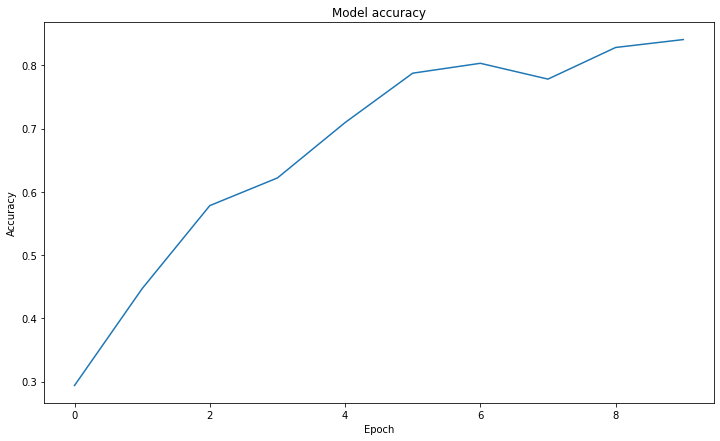

10/10 [==============================] - 1s 110ms/step - loss: 1.3335 - accuracy: 0.4875
val:  [1.3334566354751587, 0.48750001192092896]


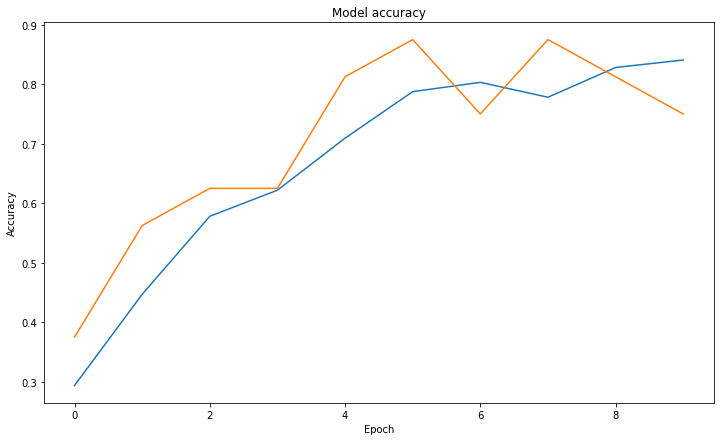

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 10s 1s/step - loss: 1.3422 - accuracy: 0.4625 - val_loss: 1.3770 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3124 - accuracy: 0.4844 - val_loss: 1.3426 - val_accuracy: 0.4875
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 1.3146 - accuracy: 0.5188 - val_loss: 1.3653 - val_accuracy: 0.4500
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.3474 - accuracy: 0.4500 - val_loss: 1.3461 - val_accuracy: 0.4125
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.3578 - accuracy: 0.4437 - val_loss: 1.3457 - val_accuracy: 0.5125
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.3316 - accuracy: 0.4875 - val_loss: 1.3354 - val_accuracy: 0.5000
Epoch 7/10
8/8 [==============================] - 10s

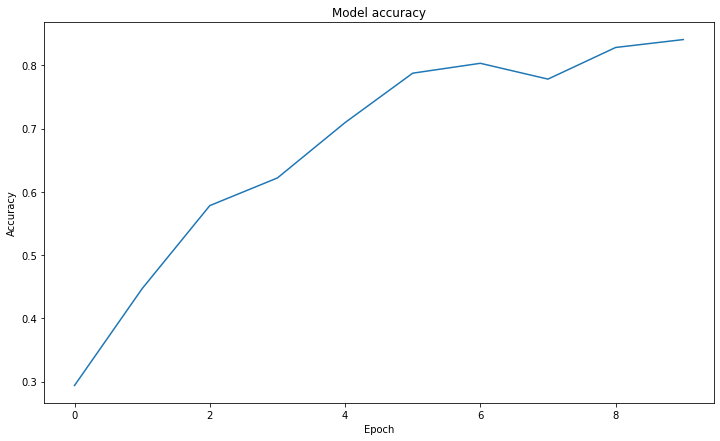

10/10 [==============================] - 1s 109ms/step - loss: 1.3485 - accuracy: 0.4125
val:  [1.348519206047058, 0.4124999940395355]


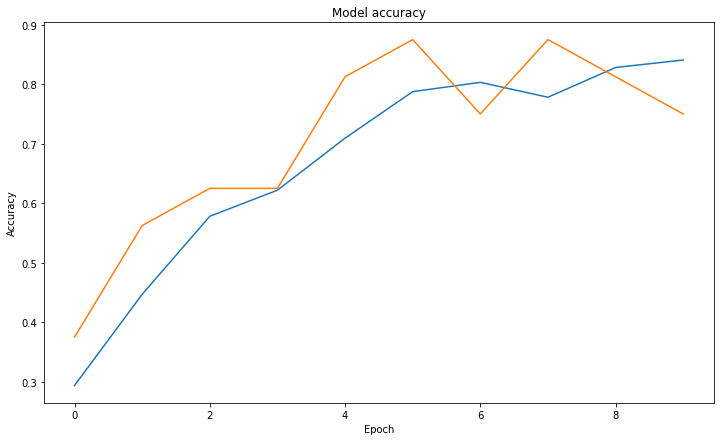

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/10
8/8 [==============================] - 11s 1s/step - loss: 1.2962 - accuracy: 0.5000 - val_loss: 1.3422 - val_accuracy: 0.4000
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1.3358 - accuracy: 0.4406 - val_loss: 1.3334 - val_accuracy: 0.4625
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1.3012 - accuracy: 0.4906 - val_loss: 1.3438 - val_accuracy: 0.5250
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.3211 - accuracy: 0.5063 - val_loss: 1.3085 - val_accuracy: 0.5125
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 1.3386 - accuracy: 0.4656 - val_loss: 1.3454 - val_accuracy: 0.4375
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 1.3331 - accuracy: 0.4594 - val_loss: 1.3211 - val_accuracy: 0.5125
Epoch 7/10
8/8 [==============================] - 10s

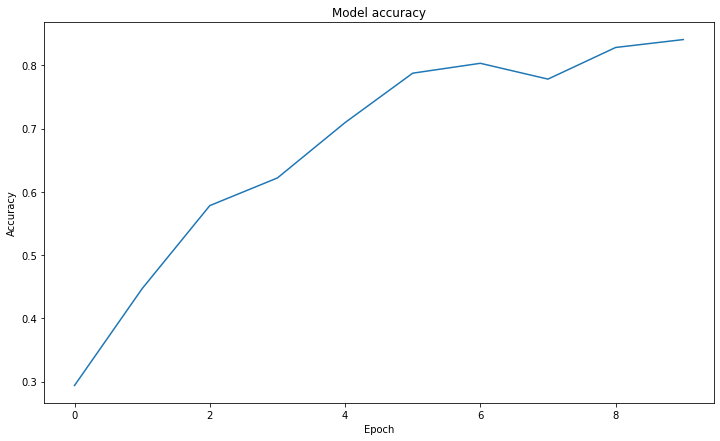

10/10 [==============================] - 1s 107ms/step - loss: 1.3180 - accuracy: 0.5000
val:  [1.318025827407837, 0.5]


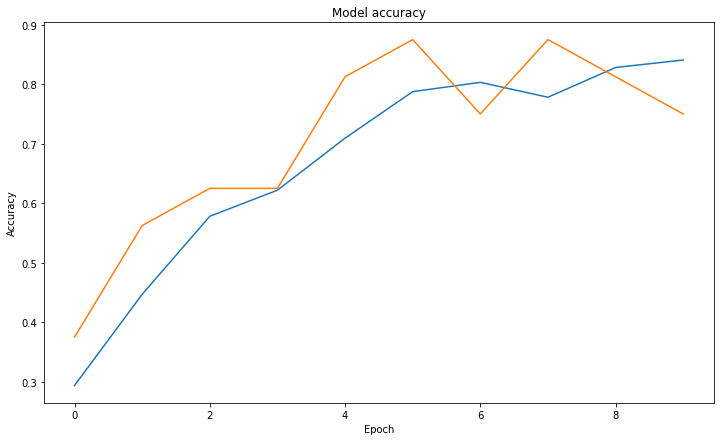

In [ ]:
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(img_data[['Path', 'Label']], img_data[['Label']], test_size=0.2, random_state=42)
Y = y_train

test_generator = test_datagen.flow_from_dataframe( dataframe=X_test, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)


for train_index, val_index in kf.split(np.zeros(400),Y):



  training_data = X_train.iloc[train_index]
  validation_data = X_train.iloc[val_index]

 
  batch_size = 40
  train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=batch_size, class_mode="categorical", subset='training', shuffle=True, seed=42)
  validation_generator = val_datagen.flow_from_dataframe( dataframe=X_val, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)

  
  history_resnet101 = model_resnet101.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch = 8, 
      epochs=10,
      callbacks = call_back)
  
  print('test: ', model_resnet101.evaluate(test_generator))
  plt.figure(figsize=(12,7))
  plt.plot(history_resnet101.history['accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

  print('val: ',model_resnet101.evaluate(validation_generator))
  plt.figure(figsize=(12,7))
  plt.plot(history_resnet101.history['accuracy'])
  plt.plot(history_resnet101.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()



#### Inception

We have val accuracy of 88 and test accuracy of 90 for epoch 2 and 2 steps and the parameters are low since we want to avoid overfitting here!

Found 100 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 0.3807 - accuracy: 0.9000 - val_loss: 0.4979 - val_accuracy: 0.8125
Epoch 2/2
13/13 [==============================] - 1s 74ms/step - loss: 0.4897 - accuracy: 0.8100
test:  [0.48970046639442444, 0.8100000023841858]


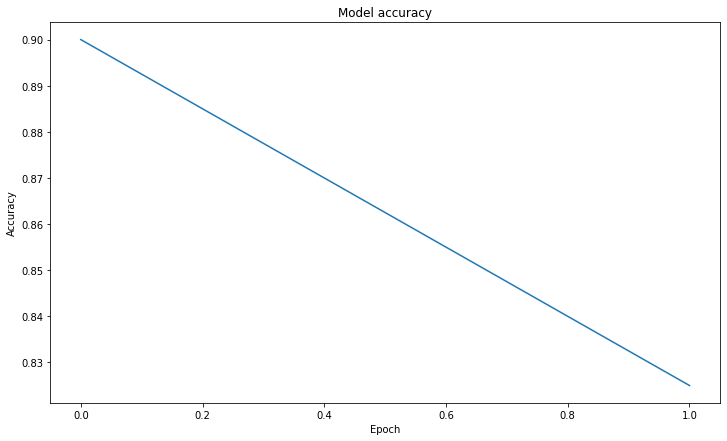

10/10 [==============================] - 1s 80ms/step - loss: 0.4389 - accuracy: 0.8250
val:  [0.43893447518348694, 0.824999988079071]


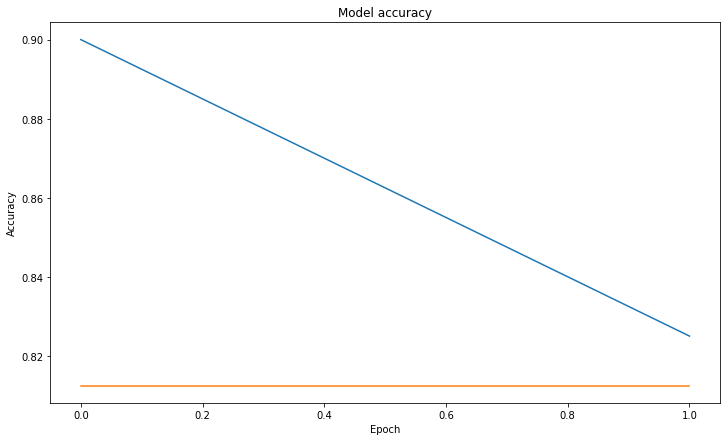

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.3368 - accuracy: 0.8750 - val_loss: 0.3732 - val_accuracy: 0.8125
Epoch 2/2
13/13 [==============================] - 1s 76ms/step - loss: 0.4187 - accuracy: 0.8500
test:  [0.41867801547050476, 0.8500000238418579]


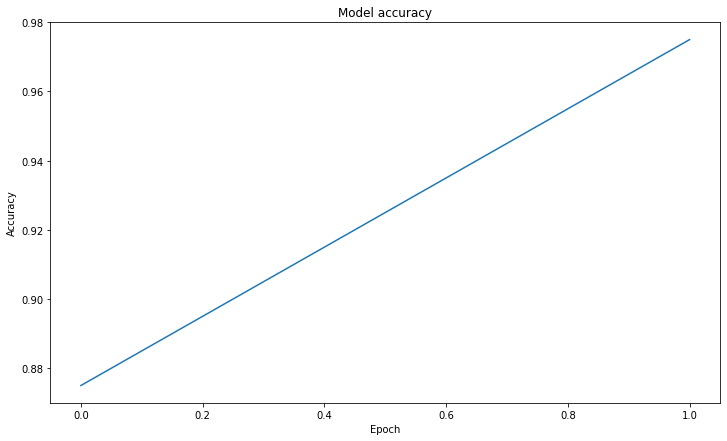

10/10 [==============================] - 1s 79ms/step - loss: 0.3329 - accuracy: 0.8750
val:  [0.332882821559906, 0.875]


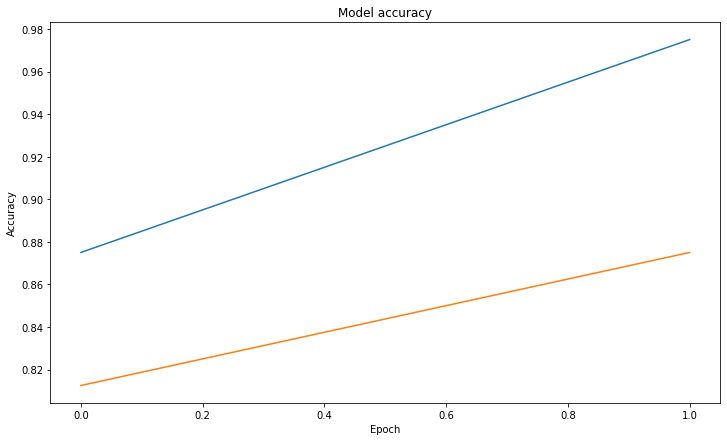

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2913 - accuracy: 0.8750 - val_loss: 0.2755 - val_accuracy: 0.9375
Epoch 2/2
13/13 [==============================] - 1s 78ms/step - loss: 0.4283 - accuracy: 0.8500
test:  [0.42828142642974854, 0.8500000238418579]


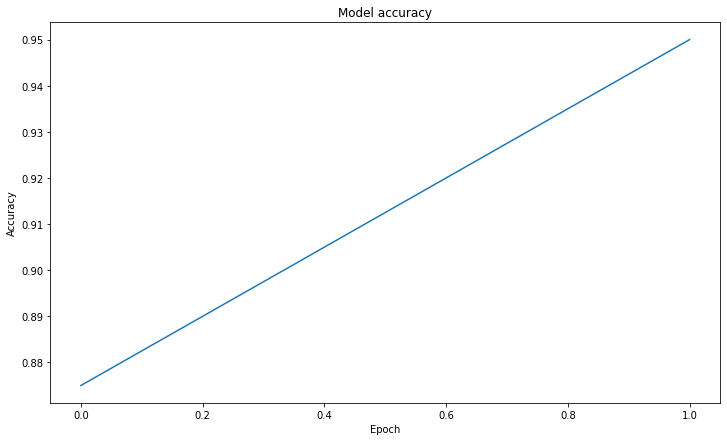

10/10 [==============================] - 1s 79ms/step - loss: 0.2892 - accuracy: 0.8750
val:  [0.28924560546875, 0.875]


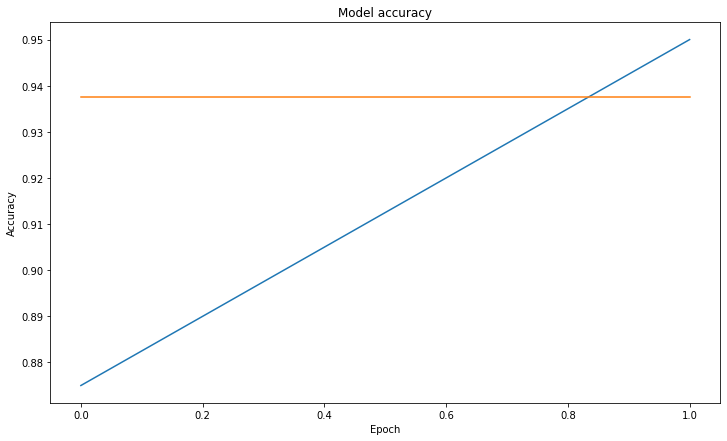

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.3825 - accuracy: 0.8750 - val_loss: 0.2609 - val_accuracy: 0.9375
Epoch 2/2
13/13 [==============================] - 1s 74ms/step - loss: 0.4483 - accuracy: 0.8700
test:  [0.4483417570590973, 0.8700000047683716]


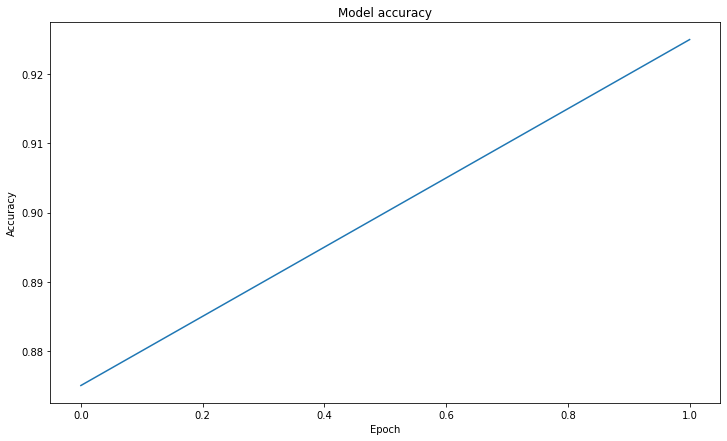

10/10 [==============================] - 1s 78ms/step - loss: 0.3036 - accuracy: 0.8750
val:  [0.3036487400531769, 0.875]


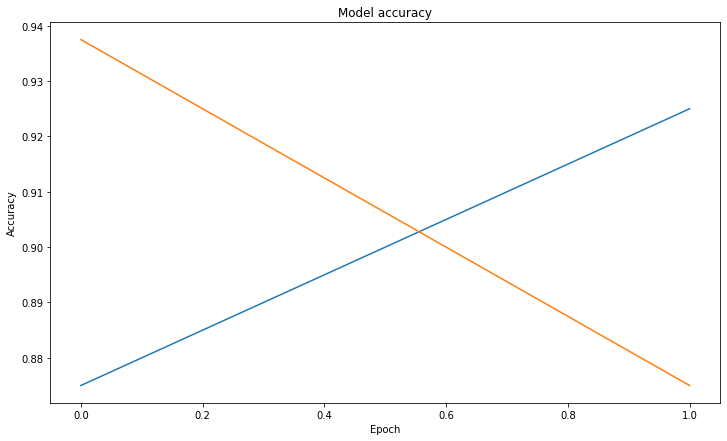

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.3910 - accuracy: 0.9000 - val_loss: 0.2600 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 74ms/step - loss: 0.3890 - accuracy: 0.8700
test:  [0.38897570967674255, 0.8700000047683716]


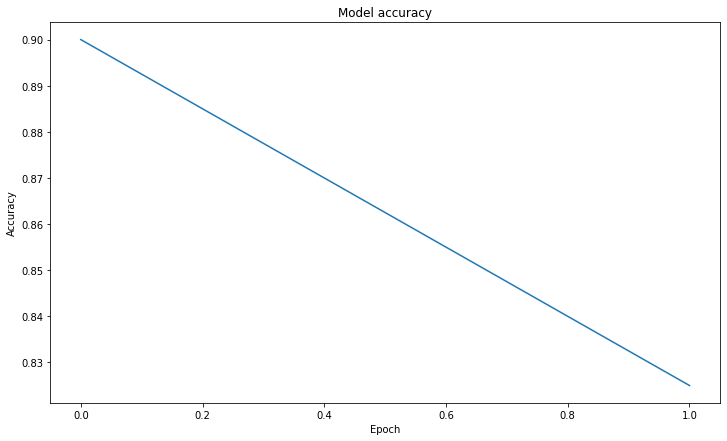

10/10 [==============================] - 1s 79ms/step - loss: 0.2765 - accuracy: 0.8875
val:  [0.27649426460266113, 0.887499988079071]


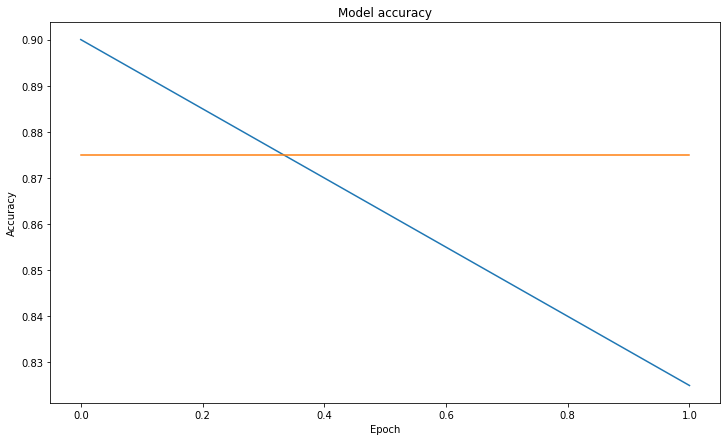

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2761 - accuracy: 0.9000 - val_loss: 0.2528 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 75ms/step - loss: 0.3495 - accuracy: 0.8900
test:  [0.3495367765426636, 0.8899999856948853]


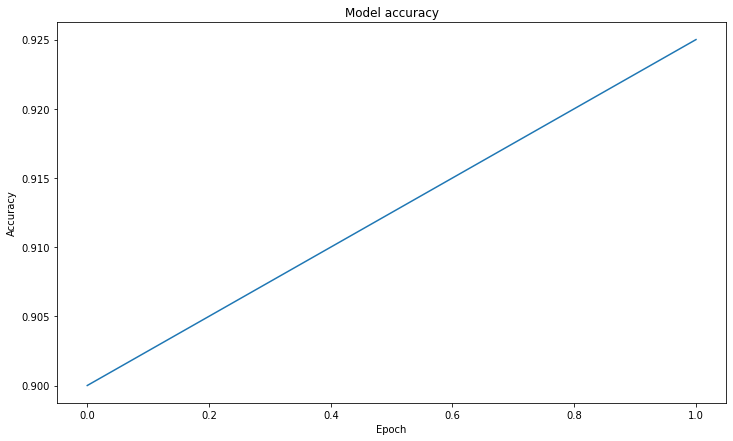

10/10 [==============================] - 1s 83ms/step - loss: 0.2500 - accuracy: 0.9000
val:  [0.25000351667404175, 0.8999999761581421]


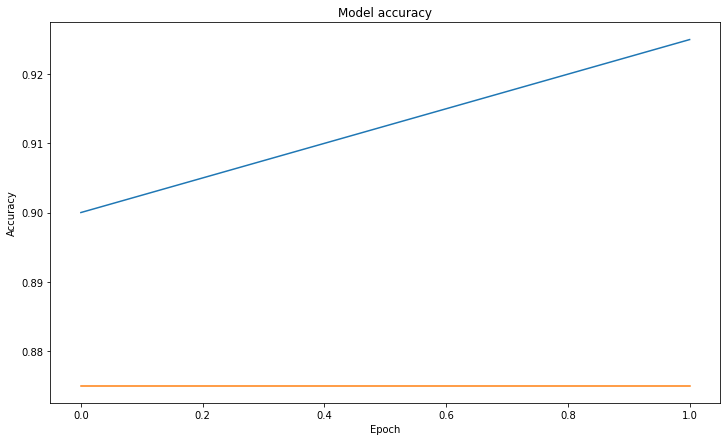

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2666 - accuracy: 0.9000 - val_loss: 0.2454 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 78ms/step - loss: 0.3437 - accuracy: 0.8900
test:  [0.34371984004974365, 0.8899999856948853]


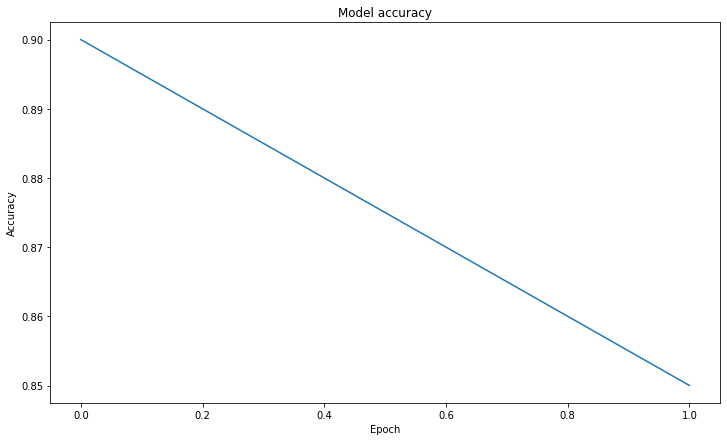

10/10 [==============================] - 1s 79ms/step - loss: 0.2447 - accuracy: 0.9000
val:  [0.24469828605651855, 0.8999999761581421]


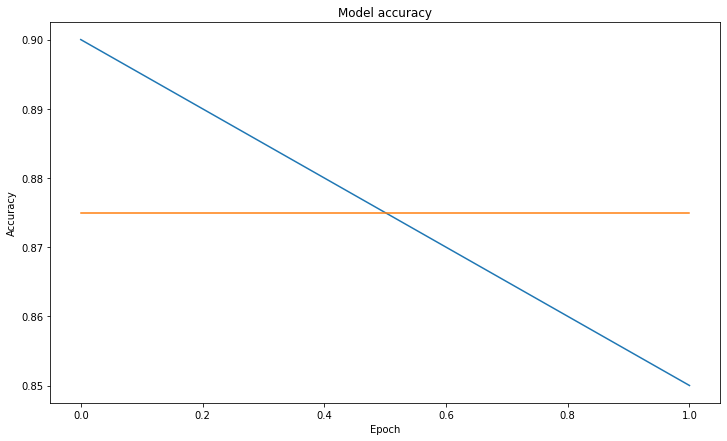

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2250 - accuracy: 0.9500 - val_loss: 0.2643 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 78ms/step - loss: 0.3515 - accuracy: 0.8700
test:  [0.3515186607837677, 0.8700000047683716]


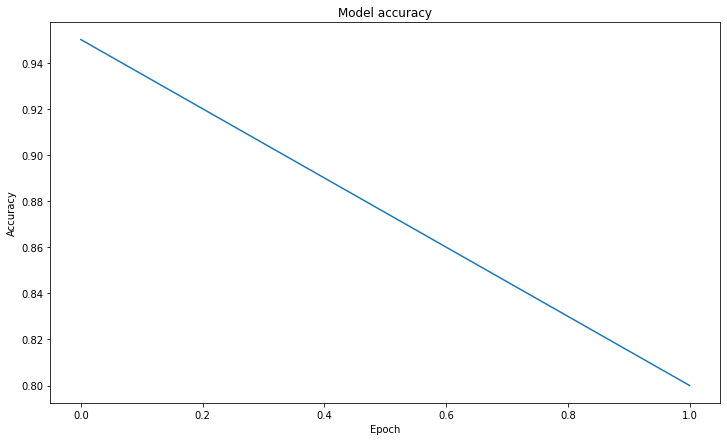

10/10 [==============================] - 1s 83ms/step - loss: 0.2486 - accuracy: 0.8875
val:  [0.24861864745616913, 0.887499988079071]


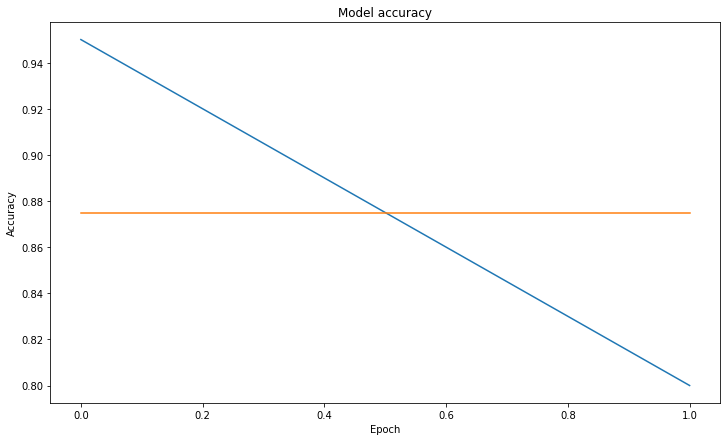

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2441 - accuracy: 0.9000 - val_loss: 0.2627 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 80ms/step - loss: 0.3493 - accuracy: 0.8800
test:  [0.34925082325935364, 0.8799999952316284]


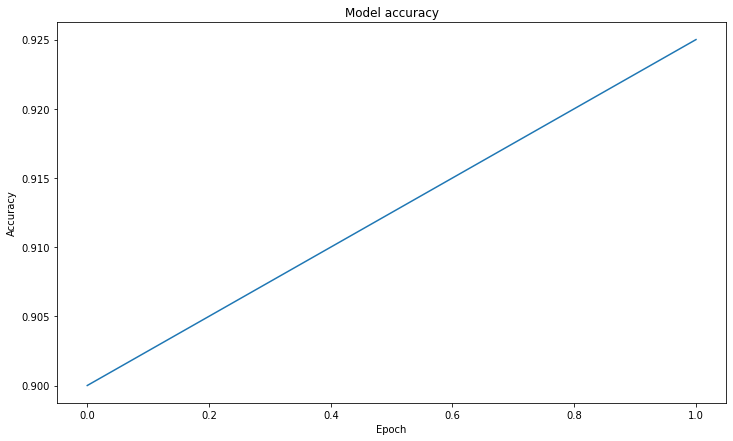

10/10 [==============================] - 1s 81ms/step - loss: 0.2416 - accuracy: 0.9000
val:  [0.24158819019794464, 0.8999999761581421]


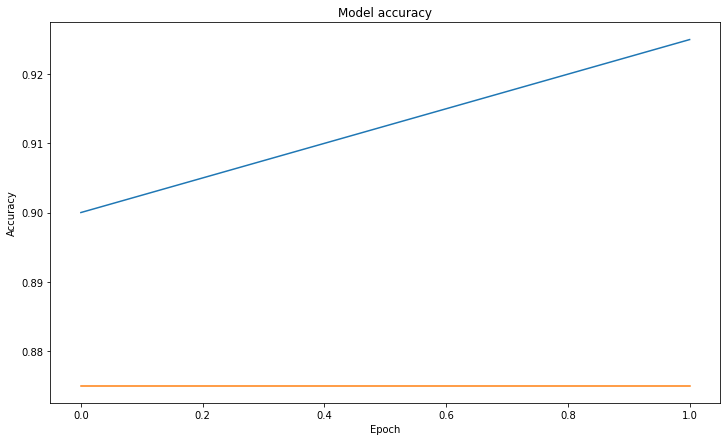

Found 400 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.2759 - accuracy: 0.8500 - val_loss: 0.2593 - val_accuracy: 0.8750
Epoch 2/2
13/13 [==============================] - 1s 81ms/step - loss: 0.3623 - accuracy: 0.8600
test:  [0.36229872703552246, 0.8600000143051147]


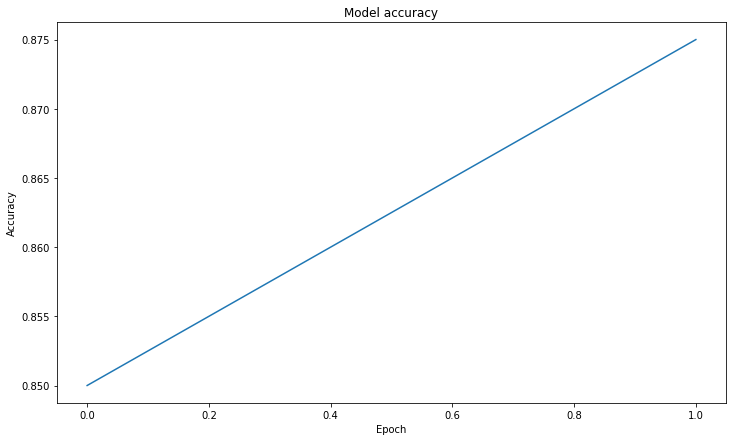

10/10 [==============================] - 1s 85ms/step - loss: 0.2468 - accuracy: 0.9125
val:  [0.24680042266845703, 0.9125000238418579]


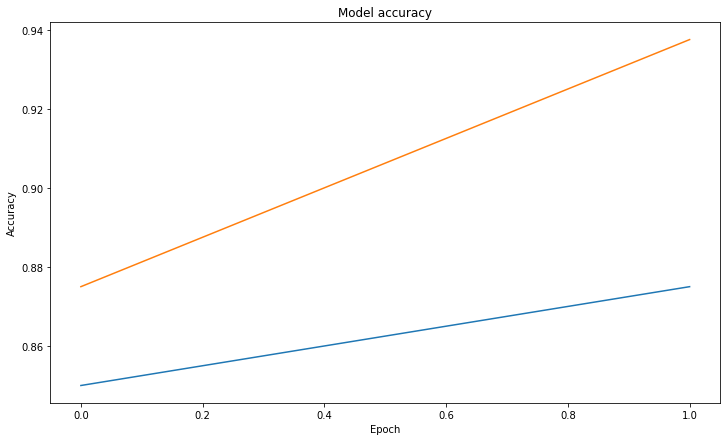

In [ ]:
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(img_data[['Path', 'Label']], img_data[['Label']], test_size=0.2, random_state=42)
Y = y_train

test_generator = test_datagen.flow_from_dataframe( dataframe=X_test, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)


for train_index, val_index in kf.split(np.zeros(400),Y):



  training_data = X_train.iloc[train_index]
  validation_data = X_train.iloc[val_index]

 
  batch_size = 40
  train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=batch_size, class_mode="categorical", subset='training', shuffle=True, seed=42)
  validation_generator = val_datagen.flow_from_dataframe( dataframe=X_val, x_col="Path", y_col="Label", target_size=(300, 300), batch_size=8, shuffle=False)

  
  inception_history = inception_model.fit(train_generator, 
                    steps_per_epoch = 1, 
                    validation_data = validation_generator,
                    validation_steps = 2,
                    epochs = 2,
                    callbacks = call_back)
  
  print('test: ', inception_model.evaluate(test_generator))
  plt.figure(figsize=(12,7))
  plt.plot(inception_history.history['accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

  print('val: ',inception_model.evaluate(validation_generator))
  plt.figure(figsize=(12,7))
  plt.plot(inception_history.history['accuracy'])
  plt.plot(inception_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()



| | VGG19 | Resnet101 | Inception |
| --- | --- | --- | |
| val_accuracy | 76 | 56 | 88 |
| test_accuracy | 79 | 62 | 90 |



It is clear that Inception is our best model yet it is prone to overfitting.

### Auto-encoder 
Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.
Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, rotation_range=20, zoom_range=0.05, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05, horizontal_flip=True, fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1 / 255.0)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
batch_size = 40

train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, x_col="Path", y_col="Label", target_size=(224, 224), batch_size=batch_size, class_mode="categorical", subset='training', shuffle=True, seed=42)

validation_generator = val_datagen.flow_from_dataframe( dataframe=X_val, x_col="Path", y_col="Label", target_size=(224, 224), batch_size=8, shuffle=False)

test_generator = test_datagen.flow_from_dataframe( dataframe=X_test, x_col="Path", y_col="Label", target_size=(224, 224), batch_size=8, shuffle=False)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
inputs = layers.Input(shape=(224, 224, 3))

# encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

In [ ]:
# decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

In [ ]:
autoencoder = Model(inputs, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 112, 112, 32)     9248

In [ ]:
# The loss is at an acceptable rate

ls =[]

for i in range(len(train_generator)):

  ls.append(train_generator[i][0][0])

ls = np.array(ls)

autoencoder_history = autoencoder.fit(ls, ls, epochs=20,shuffle = True, batch_size = 16)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.6956
Epoch 2/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6917
Epoch 3/20
1/1 [==============================] - 0s 36ms/step - loss: 0.6885
Epoch 4/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6846
Epoch 5/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6793
Epoch 6/20
1/1 [==============================] - 0s 37ms/step - loss: 0.6722
Epoch 7/20
1/1 [==============================] - 0s 33ms/step - loss: 0.6632
Epoch 8/20
1/1 [==============================] - 0s 32ms/step - loss: 0.6518
Epoch 9/20
1/1 [==============================] - 0s 35ms/step - loss: 0.6375
Epoch 10/20
1/1 [==============================] - 0s 35ms/step - loss: 0.6200
Epoch 11/20
1/1 [==============================] - 0s 33ms/step - loss: 0.5986
Epoch 12/20
1/1 [==============================] - 0s 33ms/step - loss: 0.5731
Epoch 13/20
1/1 [==============================] - 0s 35ms/step

#### VGG19

Epoch 1/25
10/10 [==============================] - 10s 959ms/step - loss: 1.3161 - accuracy: 0.6550 - val_loss: 1.3487 - val_accuracy: 0.5875
Epoch 2/25
10/10 [==============================] - 9s 908ms/step - loss: 1.3079 - accuracy: 0.6750 - val_loss: 1.3369 - val_accuracy: 0.5500
Epoch 3/25
10/10 [==============================] - 10s 1s/step - loss: 1.2945 - accuracy: 0.6575 - val_loss: 1.3412 - val_accuracy: 0.5375
Epoch 4/25
10/10 [==============================] - 13s 1s/step - loss: 1.2829 - accuracy: 0.6775 - val_loss: 1.3177 - val_accuracy: 0.5750
Epoch 5/25
10/10 [==============================] - 9s 887ms/step - loss: 1.2656 - accuracy: 0.7300 - val_loss: 1.3060 - val_accuracy: 0.5875
Epoch 6/25
10/10 [==============================] - 9s 898ms/step - loss: 1.2525 - accuracy: 0.6925 - val_loss: 1.3067 - val_accuracy: 0.5750
Epoch 7/25
10/10 [==============================] - 9s 883ms/step - loss: 1.2470 - accuracy: 0.6650 - val_loss: 1.2986 - val_accuracy: 0.5625
Epoch 8/2

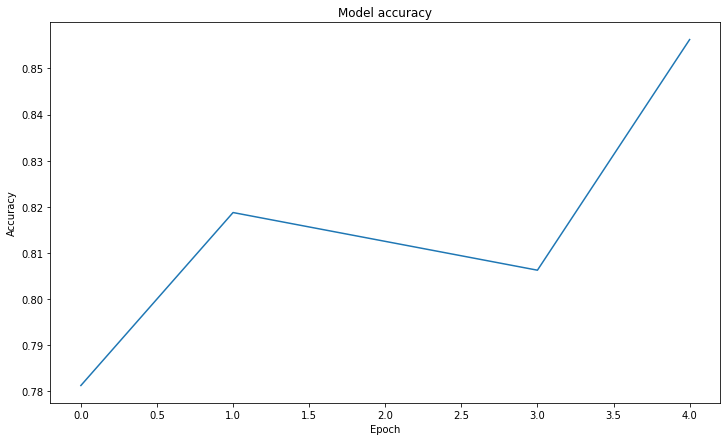

10/10 [==============================] - 1s 87ms/step - loss: 0.4340 - accuracy: 0.8875
val:  [0.4340207576751709, 0.887499988079071]


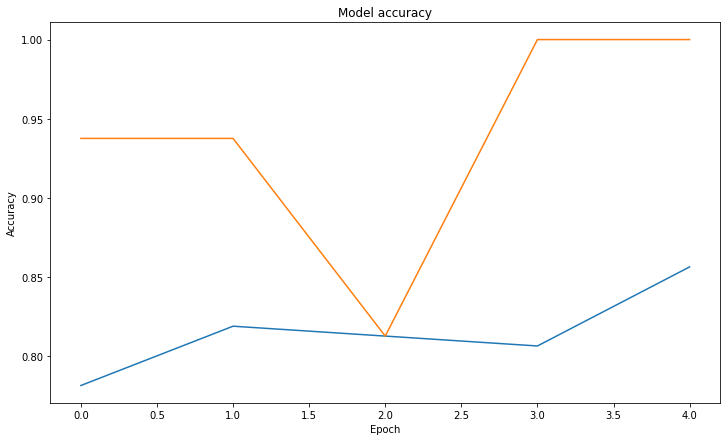

In [ ]:
history_vgg = model_vgg.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch = 10, 
      epochs=25,
      callbacks = call_back)

print('test: ', inception_model.evaluate(test_generator))
plt.figure(figsize=(12,7))
plt.plot(inception_history.history['accuracy']) # 0.85
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.show()

print('val: ',inception_model.evaluate(validation_generator))
plt.figure(figsize=(12,7))
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy']) # 0.88
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Resnet101

Epoch 1/25
8/8 [==============================] - 13s 2s/step - loss: 1.6295 - accuracy: 0.2031 - val_loss: 1.6390 - val_accuracy: 0.1625
Epoch 2/25
8/8 [==============================] - 12s 2s/step - loss: 1.6194 - accuracy: 0.2062 - val_loss: 1.6014 - val_accuracy: 0.3125
Epoch 3/25
8/8 [==============================] - 12s 2s/step - loss: 1.6129 - accuracy: 0.2188 - val_loss: 1.6067 - val_accuracy: 0.2250
Epoch 4/25
8/8 [==============================] - 14s 2s/step - loss: 1.5947 - accuracy: 0.2156 - val_loss: 1.5793 - val_accuracy: 0.3750
Epoch 5/25
8/8 [==============================] - 12s 1s/step - loss: 1.6030 - accuracy: 0.2875 - val_loss: 1.5935 - val_accuracy: 0.2500
Epoch 6/25
8/8 [==============================] - 12s 2s/step - loss: 1.6011 - accuracy: 0.1906 - val_loss: 1.5901 - val_accuracy: 0.1875
Epoch 7/25
8/8 [==============================] - 13s 2s/step - loss: 1.5887 - accuracy: 0.2875 - val_loss: 1.5683 - val_accuracy: 0.2875
Epoch 8/25
8/8 [==================

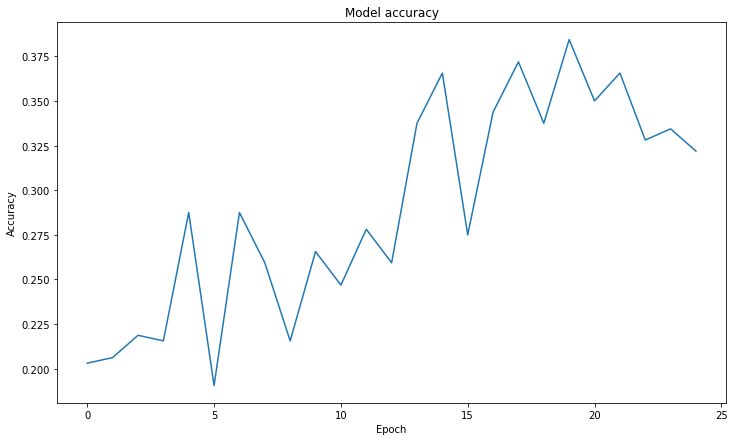

10/10 [==============================] - 2s 183ms/step - loss: 1.4499 - accuracy: 0.4500
val:  [1.4499051570892334, 0.44999998807907104]


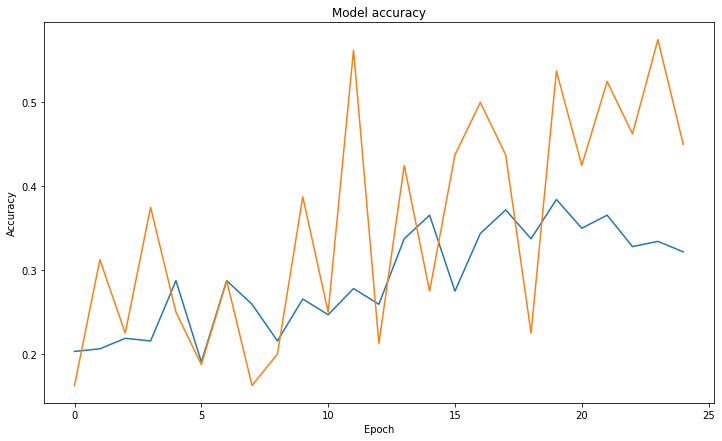

In [ ]:
history_resnet101 = model_resnet101.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 8, 
    epochs=25,
    callbacks = call_back)

print('test: ', model_resnet101.evaluate(test_generator))
plt.figure(figsize=(12,7))
plt.plot(history_resnet101.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

print('val: ',model_resnet101.evaluate(validation_generator))
plt.figure(figsize=(12,7))
plt.plot(history_resnet101.history['accuracy'])
plt.plot(history_resnet101.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Inception

Epoch 1/10
8/8 [==============================] - 68s 9s/step - loss: 0.3290 - accuracy: 0.8906 - val_loss: 0.7282 - val_accuracy: 0.6875
Epoch 2/10
8/8 [==============================] - 41s 5s/step - loss: 0.2731 - accuracy: 0.8938 - val_loss: 0.3318 - val_accuracy: 0.8750
Epoch 3/10
8/8 [==============================] - 42s 5s/step - loss: 0.3311 - accuracy: 0.8813 - val_loss: 0.5401 - val_accuracy: 0.8125
Epoch 4/10
8/8 [==============================] - 43s 5s/step - loss: 0.2835 - accuracy: 0.8938 - val_loss: 0.2093 - val_accuracy: 0.9375
Epoch 5/10
8/8 [==============================] - 42s 5s/step - loss: 0.2773 - accuracy: 0.9000 - val_loss: 0.3054 - val_accuracy: 0.8750
Epoch 6/10
8/8 [==============================] - 42s 5s/step - loss: 0.2746 - accuracy: 0.9031 - val_loss: 0.5077 - val_accuracy: 0.8750
Epoch 7/10
8/8 [==============================] - 41s 5s/step - loss: 0.2592 - accuracy: 0.9219 - val_loss: 0.4198 - val_accuracy: 0.8750
Epoch 8/10
8/8 [==================

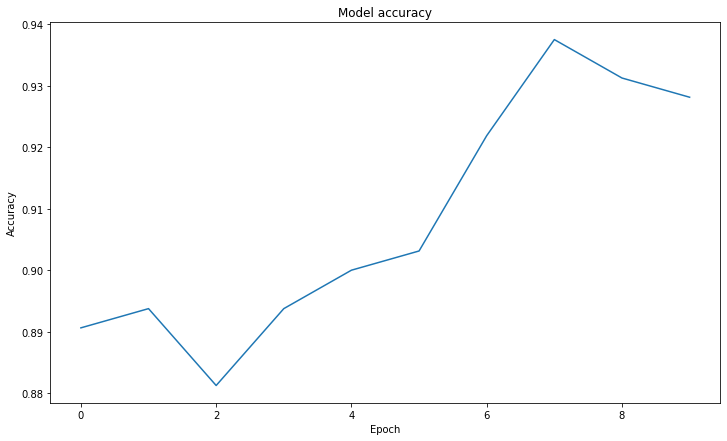

10/10 [==============================] - 10s 945ms/step - loss: 0.5777 - accuracy: 0.7875
val:  [0.5776626467704773, 0.7875000238418579]


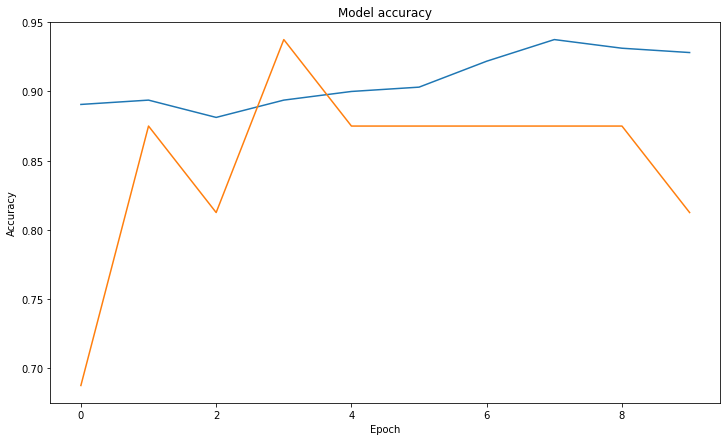

In [ ]:
inception_history = inception_model.fit(train_generator, 
                    steps_per_epoch = 8, 
                    validation_data = validation_generator,
                    validation_steps = 2,
                    epochs = 10,
                    callbacks = call_back)
  
print('test: ', inception_model.evaluate(test_generator))
plt.figure(figsize=(12,7))
plt.plot(inception_history.history['accuracy']) # 0.80
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

print('val: ',inception_model.evaluate(validation_generator))
plt.figure(figsize=(12,7))
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy']) # 0.78
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


### Conclusions

Sounds like that are results are better off without k-folds and autoencoders at the first glance; however if you look furthur, you can understand that autoencoder stopped the Inception model from overfitting and also k-folds improved the results of VGG19 and Resnet101 slightly.

#### simple pre trained models

| |  |VGG16| VGG19 | Resnet101 | Inception |
| --- | --- | --- | | ||
| val_accuracy | |70 | 65 | 48 | 93 |
| test_accuracy | | 63 |  67 | 45 | 80 |





#### 10 folds cross validation

| | VGG19 | Resnet101 | Inception |
| --- | --- | --- | |
| val_accuracy | 76 | 56 | 88 |
| test_accuracy | 79 | 62 | 90 |

#### Auto-encoder

| | VGG19 | Resnet101 | Inception |
| --- | --- | --- | |
| val_accuracy | 88 | 50 | 79 |
| test_accuracy | 85 | 45 | 78 |